In [1]:
from metpy.units import units
import metpy.calc as mpcalc
import math
from tqdm import tqdm
import time
import requests
import pytz
from pytz import timezone
from datetime import datetime, date, timezone
import sys
from epw import epw
from os import path
from codecs import open
from setuptools import setup, find_packages
from pprint import pprint
import unittest
import csv
from helper_functions import *
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from pathlib import Path
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pandas import read_csv
from hoboreader import HoboReader
import calendar
import itertools
from itertools import permutations, product
import missingno as msno
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 84em; }</style>"))

print(sys.version)
%matplotlib inline
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_rows', 100)
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 150


def get_dew_point_c(t_air_c, rel_humidity):
    """Compute the dew point in degrees Celsius
    :param t_air_c: current ambient temperature in degrees Celsius
    :type t_air_c: float
    :param rel_humidity: relative humidity in %
    :type rel_humidity: float
    :return: the dew point in degrees Celsius
    :rtype: float
    """
    A = 17.27
    B = 237.7
    alpha = ((A * t_air_c) / (B + t_air_c)) + math.log(rel_humidity / 100.0)
    return (B * alpha) / (A - alpha)

3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]


In [45]:
# DL1	Stone Garden - Tjaden Hall
# DL2	PSB Parking Lot
# DL3	Olin Library
# DL4	Milstein Hall Roof
# DL5	Game Farm Road

S1 = HoboReader("DL1_Stone_Garden_Tjaden_Hall.csv")
S2 = HoboReader("DL2_PSB_Parking_Lot.csv")
S3 = HoboReader("DL3_Olin_Library.csv")
S4 = HoboReader("DL4_Milstein_Hall_Roof.csv")
S5 = HoboReader("DL5_Game_Farm_Road.csv")

df1 = S1.get_dataframe()
df2 = S2.get_dataframe()
df3 = S3.get_dataframe()
df4 = S4.get_dataframe()
df5 = S5.get_dataframe()

# DF5 (GAME FARM ROAD) HAS TO BE SHIFTED BACK BECAUSE IT NATIVELY RECORDS DST, OUR STATIONS DO NOT.
# THE OTHER STATIONS ARE NOT SHIFTED (HENCE 0 VALUE FOR PERIODS), JUST THERE FOR SANITY

df5 = df5.shift(-2, freq="H", fill_value=0)
df4 = df4.shift(0, freq="H", fill_value=0)
df3 = df3.shift(0, freq="H", fill_value=0)
df2 = df2.shift(0, freq="H", fill_value=0)
df1 = df1.shift(0, freq="H", fill_value=0)

# Remove time zones (we are only interested in the local timezone)

df5 = df5.tz_convert(None)
df4 = df4.tz_convert(None)
df3 = df3.tz_convert(None)
df2 = df2.tz_convert(None)
df1 = df1.tz_convert(None)

#df5 = df5.tz_localize('UTC')
#df4 = df4.tz_localize('UTC')
#df3 = df3.tz_localize('UTC')
#df2 = df2.tz_localize('UTC')
#df1 = df1.tz_localize('UTC')

df5 = df5.shift(-5, freq="H", fill_value=0)
df4 = df4.shift(-5, freq="H", fill_value=0)
df3 = df3.shift(-5, freq="H", fill_value=0)
df2 = df2.shift(-5, freq="H", fill_value=0)
df1 = df1.shift(-5, freq="H", fill_value=0)

# Get rid of multiindex

df5.columns = df5.columns.droplevel(1).droplevel(2).droplevel(1).droplevel(1)
df4.columns = df4.columns.droplevel(1).droplevel(2).droplevel(1).droplevel(1)
df3.columns = df3.columns.droplevel(1).droplevel(2).droplevel(1).droplevel(1)
df2.columns = df2.columns.droplevel(1).droplevel(2).droplevel(1).droplevel(1)
df1.columns = df1.columns.droplevel(1).droplevel(2).droplevel(1).droplevel(1)

In [5]:
groton = pd.read_csv("DL6_Groton.csv")
groton_filter = groton[[
    'time_end',
    'temp_2m_avg [degC]',
    'relative_humidity_avg [percent]',
    'precip_incremental [mm]',
    #'wind_speed_prop_avg [m/s]',
    #'wind_direction_prop_avg [degrees]',
    'wind_speed_sonic_avg [m/s]',
    'wind_direction_sonic_avg [degrees]',
    'solar_insolation_avg [W/m^2]',
    'station_pressure_avg [mbar]',
]]

groton_rename = groton_filter.rename(
    columns={
        'oldName1': 'newName1',
        'oldName2': 'newName2',
        'time_end': 'DateTime',
        'temp_2m_avg [degC]': "Temp",
        'relative_humidity_avg [percent]': "RH",
        'precip_incremental [mm]': "Precipitation",
        # 'wind_speed_prop_avg [m/s]':"Wind Speed Prop",
        # 'wind_direction_prop_avg [degrees]':"Wind Direction Prop",
        'wind_speed_sonic_avg [m/s]': "Wind Speed",
        'wind_direction_sonic_avg [degrees]': "Wind Direction",
        'solar_insolation_avg [W/m^2]': "Solar Radiation",
        'station_pressure_avg [mbar]': "Pressure",
    })

df6 = groton_rename
df6.index = pd.to_datetime(df6.iloc[:, 0])
df6 = df6.shift(-2, freq="H", fill_value=0)

C:\Users\pkastner\Anaconda3\envs\hobo\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\Users\pkastner\Anaconda3\envs\hobo\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


DateTime
2018-12-31 23:00:00    0
2019-01-01 00:00:00    0
2019-01-01 01:00:00    0
2019-01-01 02:00:00    0
2019-01-01 03:00:00    0
                      ..
2021-01-01 18:00:00    0
2021-01-01 19:00:00    0
2021-01-01 20:00:00    0
2021-01-01 21:00:00    0
2021-01-01 22:00:00    0
Length: 17568, dtype: int64

In [50]:
data = {'df6': df6, 'df5': df5, 'df4': df4, 'df3': df3, 'df2': df2, 'df1': df1}


# FIX OUTLIERS ONCE AND FOR ALL
def get_bm_from_cutoff(df, variable, smallerthan, largerthan):

    bm = (df[variable].astype(float) <
          (smallerthan)) | (df[variable].astype(float) > (largerthan))

    df[variable][bm] = np.NaN

    return df


def delete_interpolate_outliers(df):

    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    # make IQR very small if 0
    IQR[IQR == 0] = 0.02

    # print(IQR)
    cutoff = 60
    bm = (df < (Q1 - cutoff * IQR)) | (df > (Q3 + cutoff * IQR))
    df[bm] = np.NaN

    # Create imputed flags for onces we can fix

    df['Imputed'] = df.isna().sum(axis=1).apply(lambda x: 0 if x == 0 else 1)
    df = df.interpolate(method='polynomial', order=2)

    # Create obvious NaNs and mark them as missing

    try:
        df = get_bm_from_cutoff(df, 'MRT', -70, 80)
        df = get_bm_from_cutoff(df, 'Gust Speed', 0, 100)
        df = get_bm_from_cutoff(df, 'RH', 0, 100)
        df = get_bm_from_cutoff(df, 'DewPt', -50, 50)
        df = get_bm_from_cutoff(df, 'Solar Radiation', 0, 2500)
        df = get_bm_from_cutoff(df, 'Wind Speed', 0, 50)
        df = get_bm_from_cutoff(df, 'Wind Direction', 0, 360)
        df = get_bm_from_cutoff(df, 'Temp', -50, 50)
    except:
        print("Missing Var")

    df['Missing'] = df.isna().sum(axis=1).apply(lambda x: 0 if x == 0 else 1)

    return df


print("DL5")
df5 = delete_interpolate_outliers(df5)
print("DL4")
df4 = delete_interpolate_outliers(df4)
print("DL3")
df3 = delete_interpolate_outliers(df3)
print("DL2")
df2 = delete_interpolate_outliers(df2)
print("DL1")
df1 = delete_interpolate_outliers(df1)

print("DL6")
df6['Missing'] = df6.isna().sum(axis=1).apply(lambda x: 0 if x == 0 else 1)
df6 = df6.interpolate()
# df6.iloc[11090:11120,:]

for key, df in data.items():
    try:
        cnt_i = (df['Imputed'] == 1).sum()
        print(key, "has", cnt_i, "inputed observations.")
        cnt_m = (df['Missing'] == 1).sum()
        print(key, "has", cnt_m, "missing observations.")
    except:
        pass

DL5
Missing Var

C:\Users\pkastner\Anaconda3\envs\hobo\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
C:\Users\pkastner\Anaconda3\envs\hobo\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`



DL4


C:\Users\pkastner\Anaconda3\envs\hobo\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
C:\Users\pkastner\Anaconda3\envs\hobo\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


DL3


C:\Users\pkastner\Anaconda3\envs\hobo\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
C:\Users\pkastner\Anaconda3\envs\hobo\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


DL2


C:\Users\pkastner\Anaconda3\envs\hobo\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
C:\Users\pkastner\Anaconda3\envs\hobo\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


DL1


C:\Users\pkastner\Anaconda3\envs\hobo\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
C:\Users\pkastner\Anaconda3\envs\hobo\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


DL6
df5 has 1024 inputed observations.
df4 has 8878 inputed observations.
df3 has 402 inputed observations.
df2 has 0 inputed observations.
df1 has 925 inputed observations.


In [221]:
# Fix S5 messed up Format
#S5 = pd.read_csv("DL5_Game_Farm_Road_2020.csv")
## Create datetime from messed up column
#dt = pd.to_datetime(S5.iloc[1:,1].values)
#dt
#s = dt.strftime('%m/%d/%y %#I:%M:%S %p')
#S5.iloc[1:,1] = s
#S5.index = S5.iloc[:,0]
##S5.drop("#" )
#SS5 = S5.drop(columns = "Plot Title: DL5")
#SS5
#S5.to_csv("DL5_Game_Farm_Road_2.csv", index= None)

interactive(children=(IntSlider(value=4, description='var_id', max=8, min=1), IntSlider(value=4, description='…

<function __main__.plot(var_id, period_len, day, resample_len, month, year)>

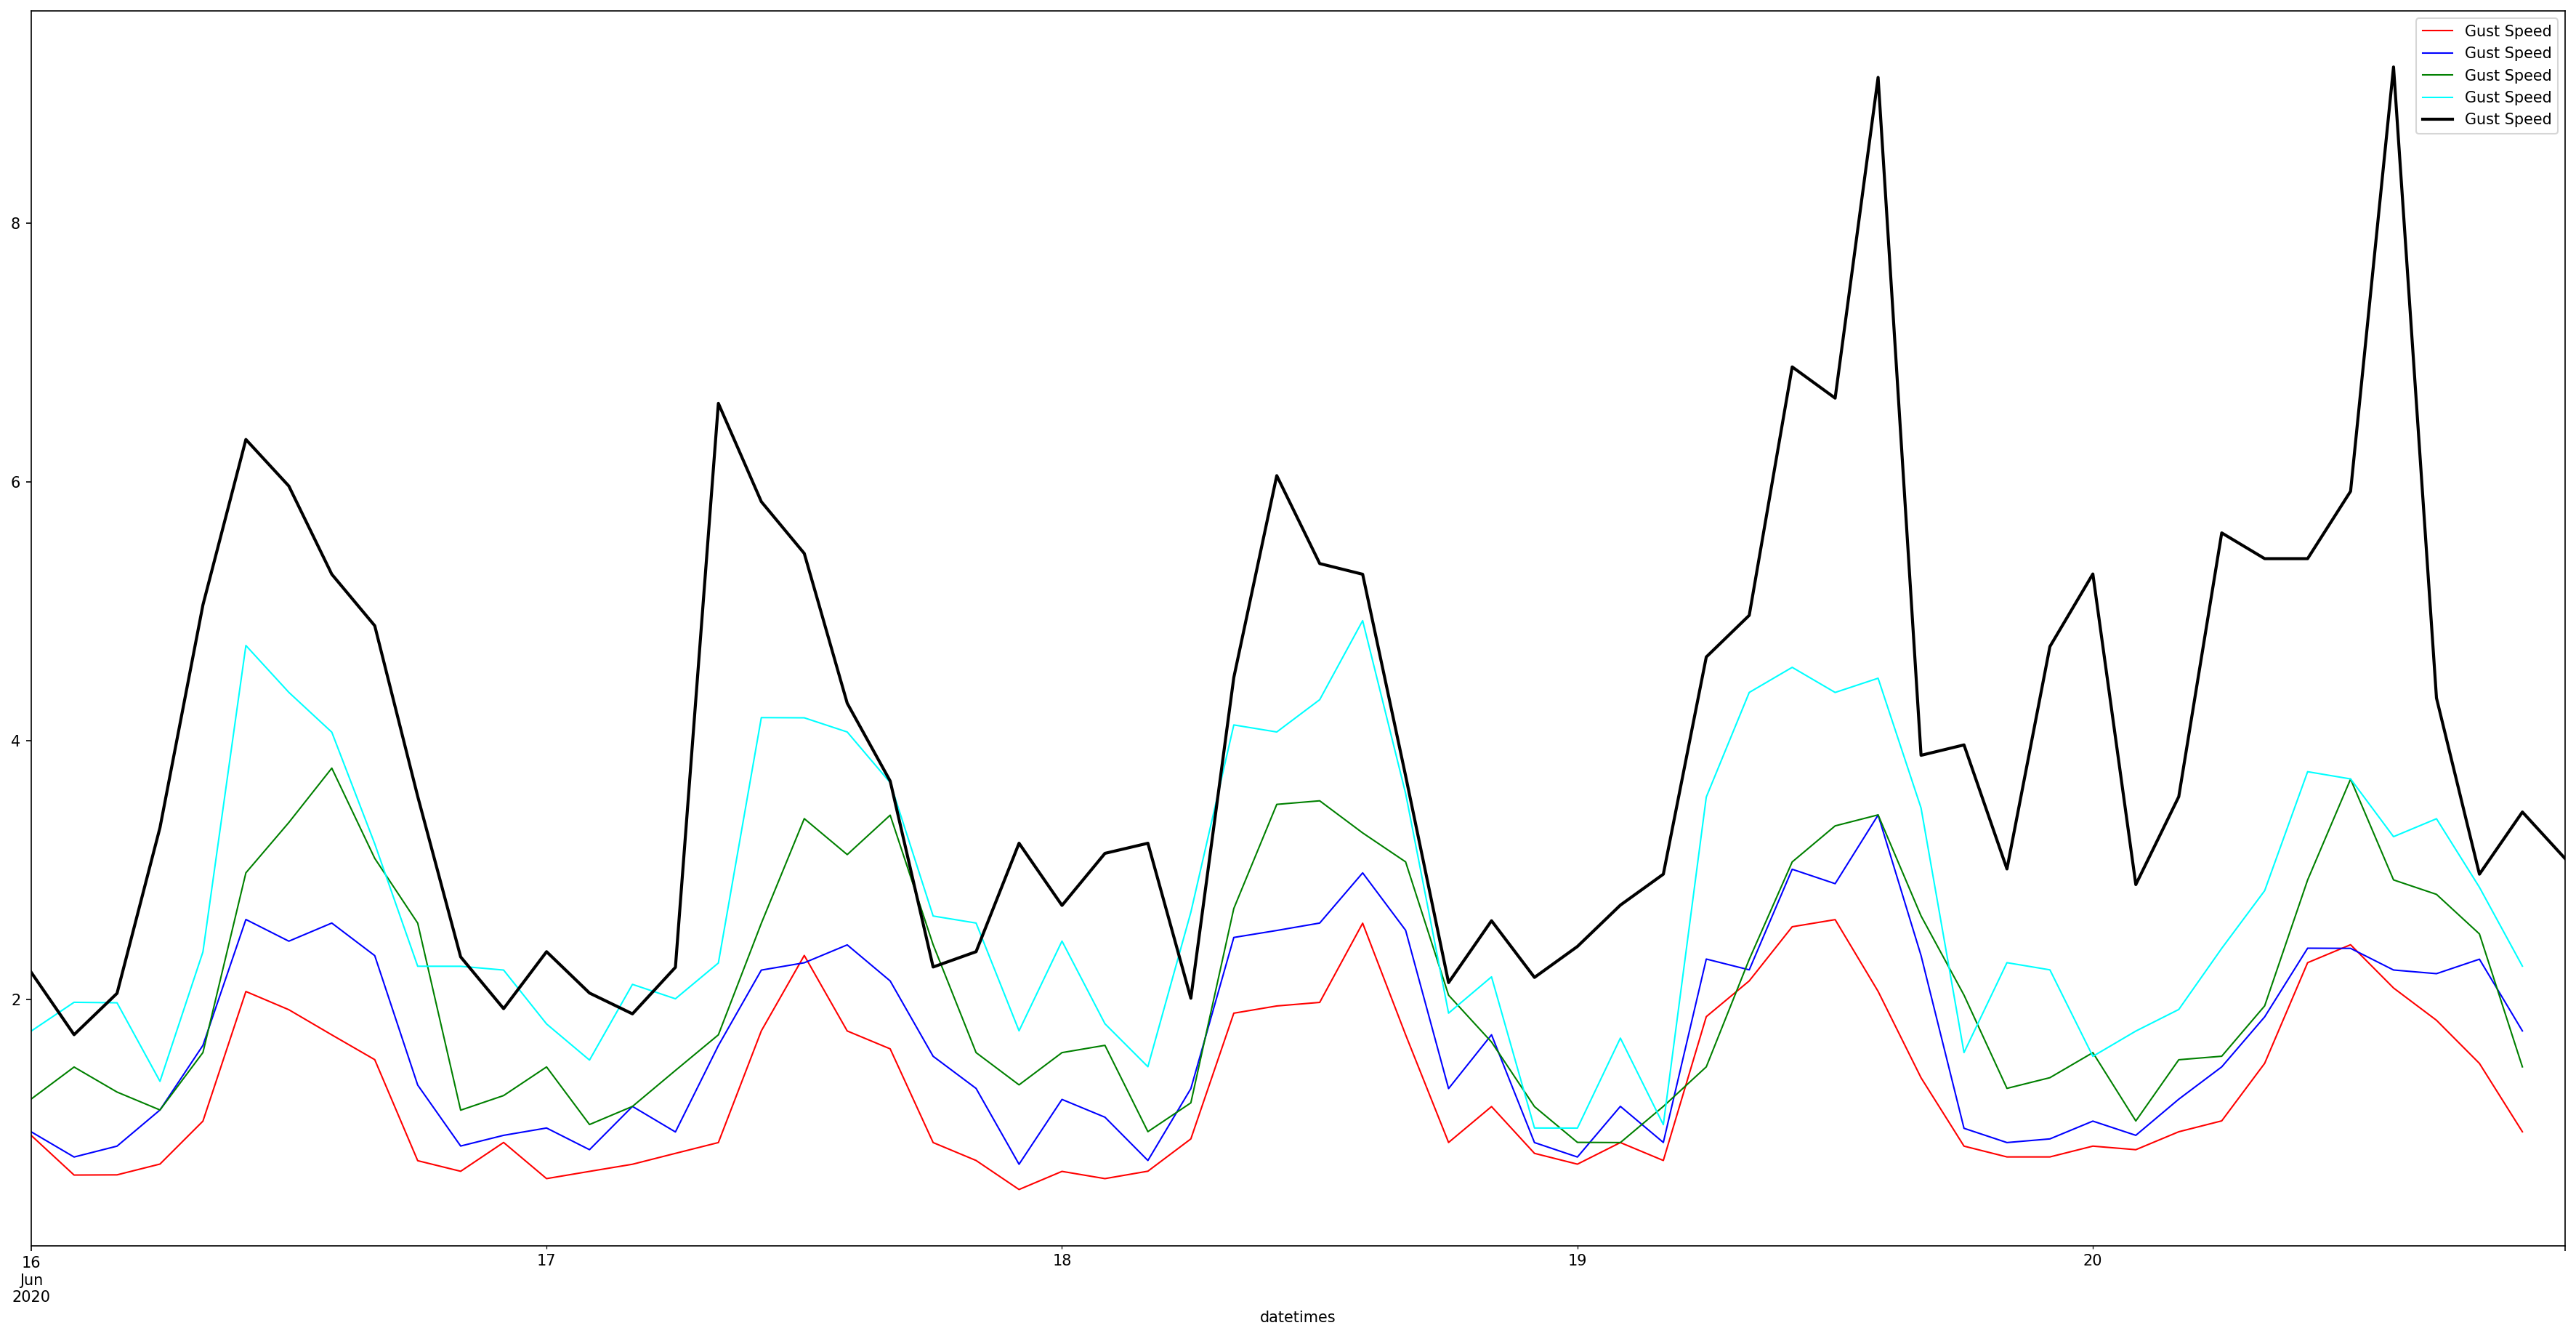

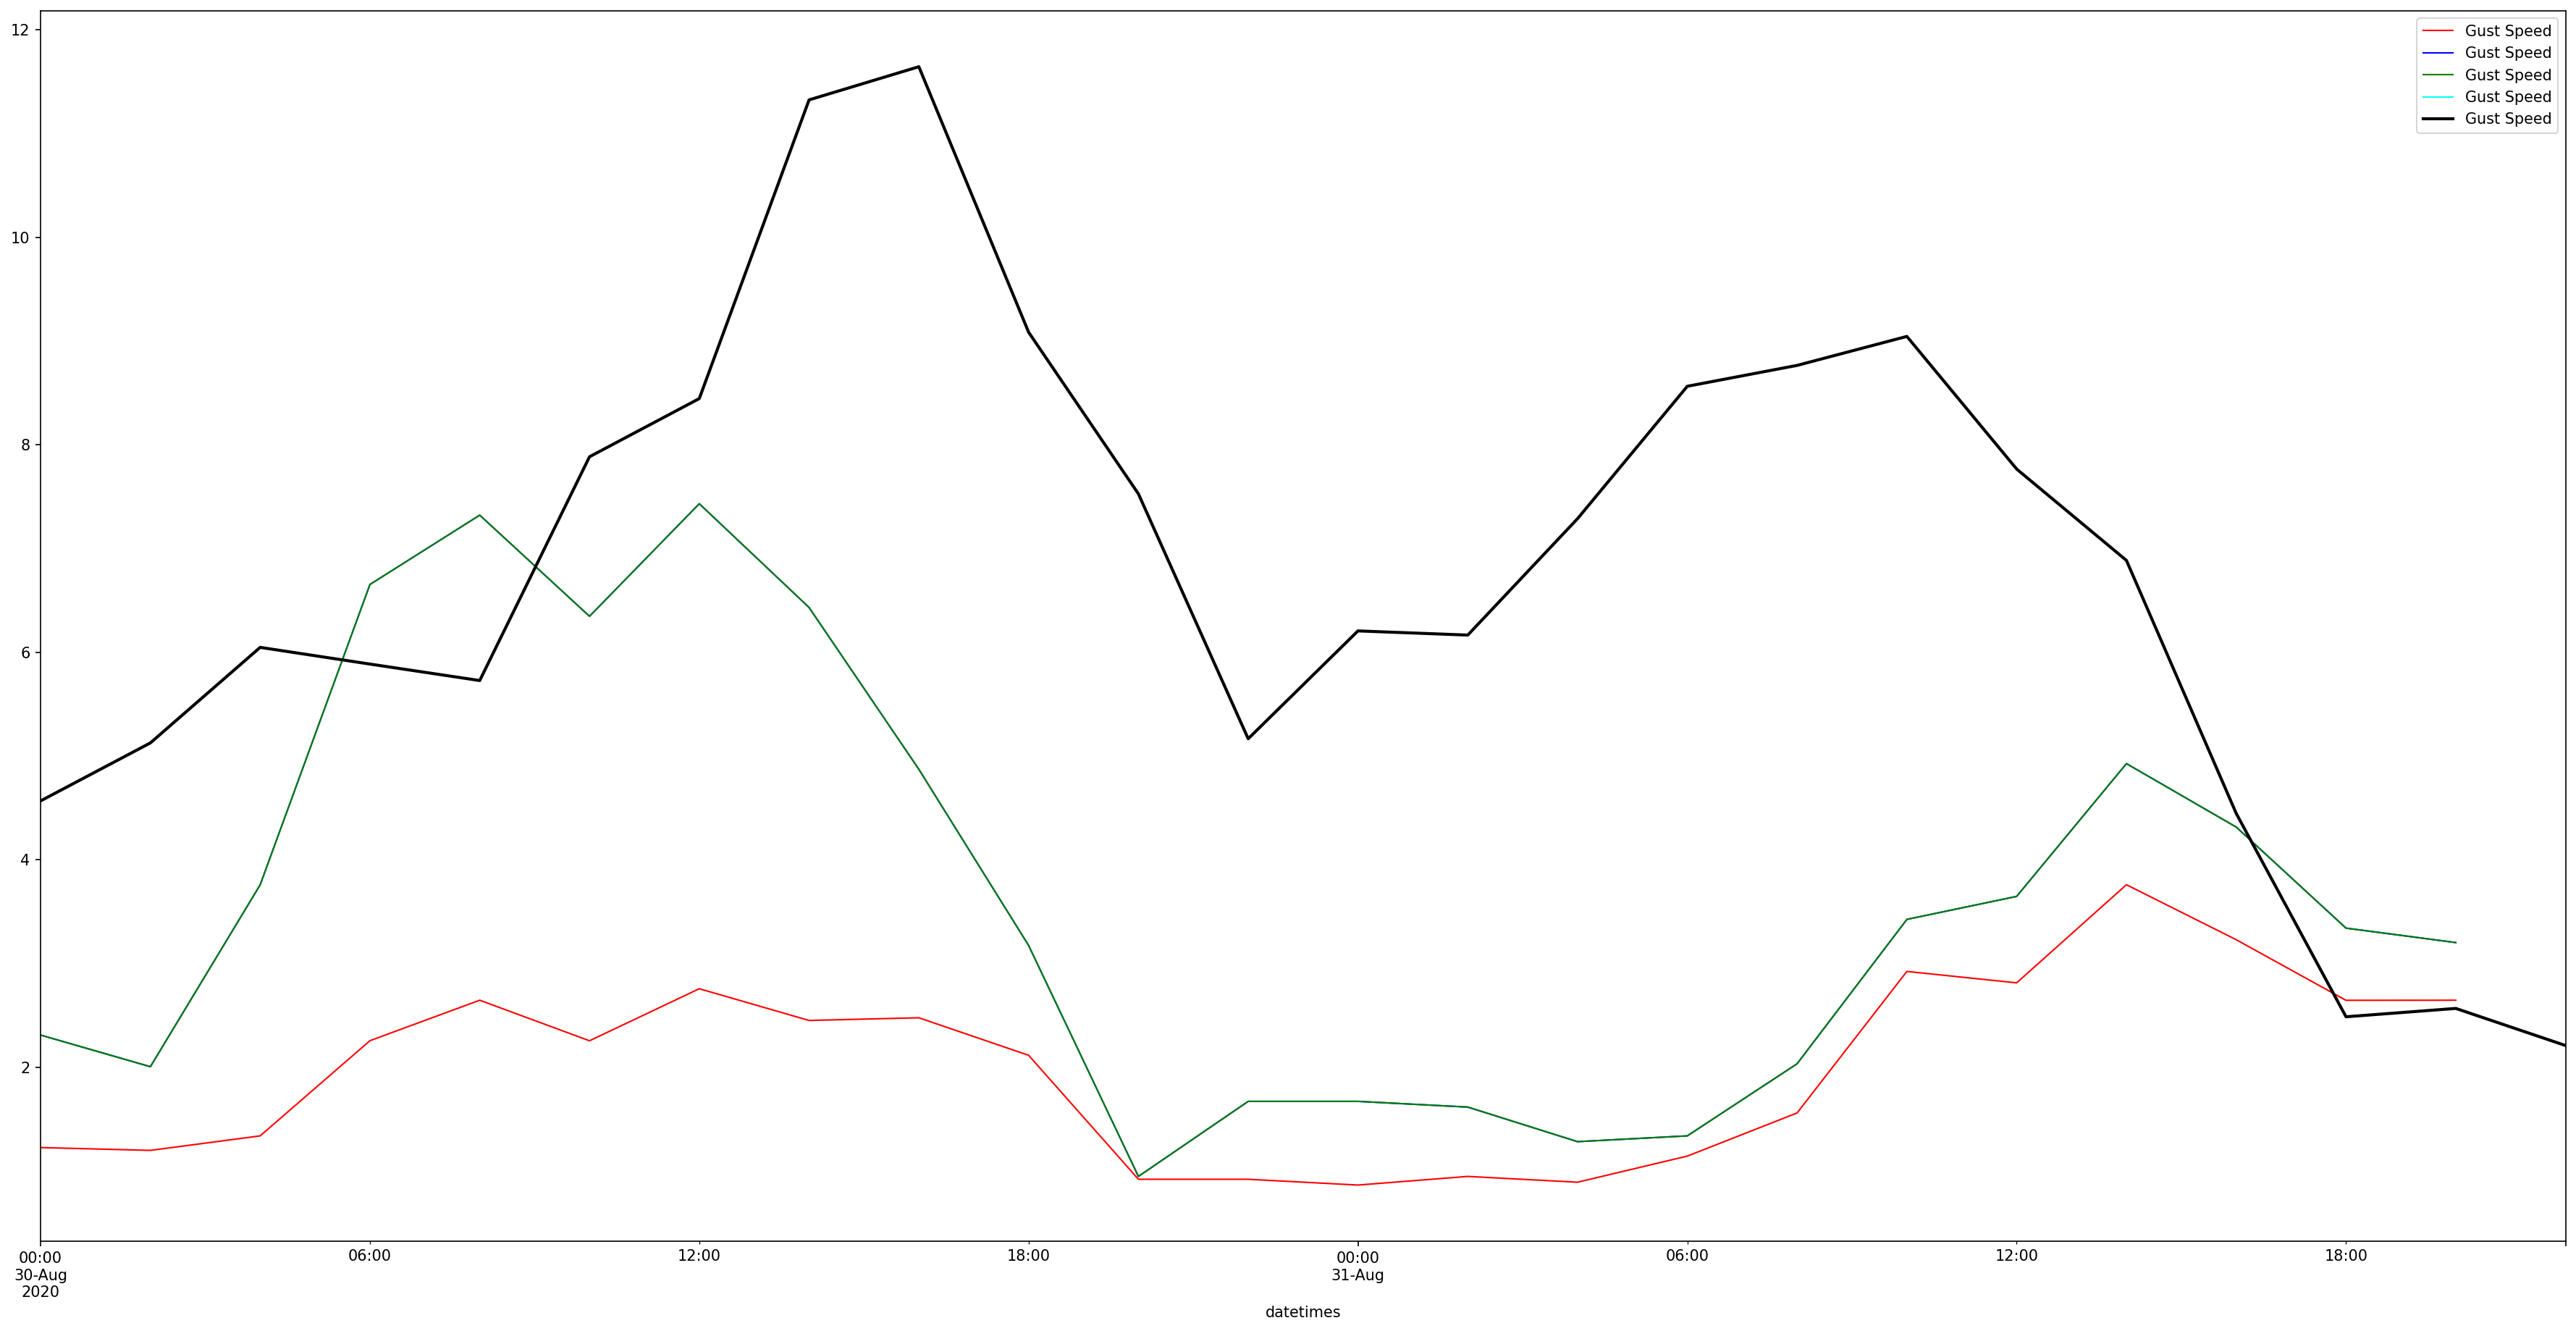

In [374]:
def plot(var_id, period_len, day, resample_len, month, year):

    start_time = str(year) + '-' + str(month) + '-' + str(day) + ' 00:00:00'
    end_time = str(year) + '-' + str(month) + '-' + \
        str(day + period_len) + ' 22:00:00'

    df1_ = df1.loc[start_time:end_time]
    df2_ = df2.loc[start_time:end_time]
    df3_ = df3.loc[start_time:end_time]
    df4_ = df4.loc[start_time:end_time]
    df5_ = df5.loc[start_time:end_time]
    df6_ = df6.loc[start_time:end_time]

    # Resample subhourly data to 1 hourly graph (OUR STATIONS RECORD IN 10MIN INTERVALS, GFR IN 1HR, RESAMPLE FOR EASY COMPARISON. CAN TURN OFF)
    df1_ = df1_.resample(str(resample_len) + 'H').mean()
    df2_ = df2_.resample(str(resample_len) + 'H').mean()
    df3_ = df3_.resample(str(resample_len) + 'H').mean()
    df4_ = df4_.resample(str(resample_len) + 'H').mean()
    df5_ = df5_.resample(str(resample_len) + 'H').mean()
    #df6_ = df6_.resample(str(resample_len) + 'H').mean()

    # Resize figure
    cf = (30, 15)

    vars = [
        "Wind Speed", "MRT", "Temp", "RH", "Solar Radiation", "Wind Speed",
        "Gust Speed", "Wind Direction", "DewPt"
    ]

    var = vars[var_id]

    # Plot both temp and mrt when temp is selected

    if var == "Temp":
        # Plot two dataframes into one plot
        ax = df1_.plot(y=var, lw=2, figsize=cf, color='red')
        df2_.plot(y=var, lw=2, figsize=cf, color='blue', ax=ax)
        df3_.plot(y=var, lw=2, figsize=cf, color='green', ax=ax)
        df4_.plot(y=var, lw=2, figsize=cf, color='aqua', ax=ax)
        df5_.plot(y=var, lw=3.5, figsize=cf, color='black', ax=ax)
        df6_.plot(y=var, lw=3.5, figsize=cf, color='purple', ax=ax)

        ax = df1_.plot(y="MRT",
                       lw=1,
                       figsize=cf,
                       style=['--'],
                       color='red',
                       ax=ax)
        df2_.plot(y="MRT", lw=1, figsize=cf, style=['--'], color='blue', ax=ax)
        df3_.plot(y="MRT",
                  lw=1,
                  figsize=cf,
                  style=['--'],
                  color='green',
                  ax=ax)
        df4_.plot(y="MRT", lw=1, figsize=cf, style=['--'], color='aqua', ax=ax)

    else:
        # Plot two dataframes into one plot
        ax = df1_.plot(y=var, lw=1, figsize=cf, color='red')
        df2_.plot(y=var, lw=1, figsize=cf, color='blue', ax=ax)
        df3_.plot(y=var, lw=1, figsize=cf, color='green', ax=ax)
        df4_.plot(y=var, lw=1, figsize=cf, color='aqua', ax=ax)
        df5_.plot(y=var, lw=2, figsize=cf, color='black', ax=ax)
        df6_.plot(y=var, lw=2, figsize=cf, color='purple', ax=ax)

    # Legend
    ax.legend([
        "DL1 - Stone Garden - Tjaden Hall", "DL2 - PSB Parking Lot",
        "DL3 - Olin Library", "DL4 - Milstein Hall Roof ",
        "DL5 - Game Farm Road", "DL6 - Groton"
    ],
              loc='upper left',
              frameon=False,
              fontsize=20)

    # Fix xticks

    ax.tick_params(axis='both', which='minor', labelsize=22)
    ax.tick_params(axis='both', which='major', labelsize=22)

    # Labels
    plt.ylabel(var, fontname="Consolas", fontsize=26)
    plt.xlabel("Time", fontname="Consolas", fontsize=26)

    # Title
    ax.set_title(str(
        start_time.split(' ')[0] + " "
        'to'
        " " + end_time.split(' ')[0] + " " + var),
                 fontname="Consolas",
                 fontsize=28)


# variable to plot
# 1 = "MRT °C"
# 2 = "Temp °C"
# 3 = "RH"
# 4 = "Solar Radiation"
# 5 = "Wind Speed"
# 6 = "Gust Speed"
# 7 = "Wind Direction"
# 8 = "DewPt"

interact(plot,
         var_id=(1, 8, 1),
         period_len=(1, 7, 1),
         resample_len=(1, 4, 1),
         day=(1, 31, 1),
         month=(1, 12, 1),
         year=(2019, 2021, 1))

# 2020 5 12

In [51]:
# Reindl split test
from gen_reindl import *

# Create date series using date_range() function
#date_series = pd.date_range('01/01/2019', periods=8760, freq='H')
# print(date_series)

# altitude M Station (although not necessary for gen_reindl)
altitude = 255

# lat, lon taken from STATION
lat = 42.45062  # north-positive
lon = 76.48120  # west-positive for Reindl split (Alstan)

# Then the gen_reindl program can be run. -l is longitude (west positive),
# -a is latitude (north positive) and -m is the time zone in a multiple of
# 15 degrees from the meridian. The command below is for Singapore, and
# you note that it is in the wrong time zone. UTC+8 * 15 = -120, despite a
# -103.98 longitude.
# > gen_reindl -m -120 -l -103.98 -a 1.37 -i input.txt -o output.wea

# pos
time_zone = 5 * 15  # west-positive

# print("month, day, time, GHR\n")

# %timeit GenReindl(lat, lon, time_zone).calc_split(4, 22, 8.333333333, 107)

def calc_split_df(df):
    idx = df.index
    solar_rad_column = df.columns.get_loc('Solar Radiation')
    GHR = df.iloc[:, solar_rad_column].astype('float')
    
    # temporary bitmask
    bm = df.isna()
    df.fillna(0) 

    gr = GenReindl(lat, lon, time_zone)    
    DNI, DHR = gr.calc_split_vectorized(gr, idx.month, idx.day, idx.hour, GHR)
    
    # back to NaN for missing values    
    df[bm] = np.NaN

    df['DHR'] = DHR
    df['DNI'] = DNI

    return df

test1 = calc_split_df(df3)
test1
test1[['Solar Radiation', 'DHR', 'DNI']].loc['2019-06-06']

C:\Users\pkastner\Anaconda3\envs\hobo\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning: invalid value encountered in calc_split (vectorized)
  outputs = ufunc(*inputs)


title,Solar Radiation,DHR,DNI
datetimes,,,


In [52]:
def get_1y_data(df1, year):
    #start = datetime(int(year), 1, 1, 0, 0, tzinfo=utc)
    #end = datetime(int(year), 12, 31, 23, 0, tzinfo=utc)


    dty = pd.date_range(datetime(int(year), 1, 1, 0, 0),
                        datetime(int(year), 12, 31, 23, 0),
                        freq="H")

    #df1 = df.reindex(dty, fill_value=9999)
    df2 = df1.resample('H').mean()
    df3 = df2.reindex(dty)

    return df3

#df5
#get_1y_data(df5, 2020)

In [53]:
def make_epw(title, year, hobo_df_all, remove_leap_year):

    e = epw()

    e.headers = {
        'LOCATION': [
            'Ithaca', 'NY', 'USA', 'TMY3', '725190', '42.43', '-76.49', '-5.0',
            '125.0'
        ],
        'DESIGN CONDITIONS': [],
        'TYPICAL/EXTREME PERIODS': [],
        'GROUND TEMPERATURES': [],
        'HOLIDAYS/DAYLIGHT SAVINGS': [],
        'COMMENTS 1': [],
        'COMMENTS 2': [],
        'DATA PERIODS': []
    }

    # print(e.headers)

    #variables = ["Wind Speed","MRT","Temp","RH","Solar Radiation","Wind Speed","Gust Speed","Wind Direction","DewPoint" ]

    dt = pd.date_range(datetime(int(year), 1, 1, 0, 0),
                       datetime(int(year), 12, 31, 23, 0),
                       freq="H")

    hobo_df = calc_split_df(hobo_df_all)
    try:
        hobo_df = hobo_df.tz_convert(None)
    except:
        "has no timezone"
    hobo_df = hobo_df.resample('H').mean()
    hobo_df = hobo_df.reindex(dt, fill_value=9999)

    missing_values = hobo_df['Missing']

    if calendar.isleap(year):
        hours = 8784
    #    #missing_values = np.array(np.ones(8784) * 999999).astype(int)
    #    missing_values = hobo_df['Missing']
    else:
        hours = 8760
    #    #missing_values = np.array(np.ones(8760) * 999999).astype(int)
    #    missing_values = hobo_df['Missing']

    edf = e.dataframe

    edf['Year'] = dt.year.astype(int)
    edf['Month'] = dt.month.astype(int)
    edf['Day'] = dt.day.astype(int)
    edf['Hour'] = dt.hour.astype(int) + 1
    edf['Minute'] = dt.minute.astype(int)
    edf['Data Source and Uncertainty Flags'] = missing_values

    # Actual file starts here
    edf['Dry Bulb Temperature'] = hobo_df['Temp'].values.flatten()

    # missing_values
    if 'DewPt' in hobo_df:
        edf['Dew Point Temperature'] = hobo_df['DewPt'].values.flatten()
    else:
        edf['Dew Point Temperature'] = hobo_df.apply(
            lambda x: get_dew_point_c(x['Temp'], x['RH']),
            axis=1).values.flatten()

    edf['Relative Humidity'] = hobo_df['RH'].values.flatten()

    # Added NREL pressure 2020-08-21
    if 'Pressure' in hobo_df:
        edf['Atmospheric Station Pressure'] = hobo_df[
            'Pressure'].values.flatten()
    else:
        edf['Atmospheric Station Pressure'] = missing_values

    edf['Extraterrestrial Horizontal Radiation'] = missing_values
    #
    edf['Extraterrestrial Direct Normal Radiation'] = missing_values
    #
    edf['Horizontal Infrared Radiation Intensity'] = missing_values
    #
    edf['Global Horizontal Radiation'] = hobo_df[
        'Solar Radiation'].values.flatten()
    edf['Direct Normal Radiation'] = hobo_df['DNI'].values.flatten()
    edf['Diffuse Horizontal Radiation'] = hobo_df['DHR'].values.flatten()

    # Do we need this?
    # https://www.radiance-online.org//pipermail/radiance-general/2013-January/009140.html ?
    edf['Global Horizontal Illuminance'] = hobo_df['Solar Radiation'].values.flatten() * \
        179
    edf['Direct Normal Illuminance'] = hobo_df['DNI'].values.flatten() * 179
    edf['Diffuse Horizontal Illuminance'] = hobo_df['DHR'].values.flatten(
    ) * 179

    edf['Zenith Luminance'] = missing_values

    edf['Wind Direction'] = hobo_df['Wind Direction'].values.flatten().astype(
        int)
    edf['Wind Speed'] = hobo_df['Wind Speed'].values.flatten()

    if 'SkyCover' in hobo_df:

        # not sure which one to use (skycover)
        edf['Total Sky Cover'] = hobo_df['SkyCover'].replace(
            ' -',
            '1.0').astype(float).multiply(10).astype(int).values.flatten()
        #     This is from Ithaca airport data (NWS, NOAA) (ADDED TO DL5_2019 FILE 07.22.2020)
        #  (used if Horizontal IR Intensity missing)
        edf['Opaque Sky Cover'] = hobo_df['SkyCover'].replace(
            ' -',
            '1.0').astype(float).multiply(10).astype(int).values.flatten()
    else:
        edf['Total Sky Cover'] = missing_values
        edf['Opaque Sky Cover'] = missing_values

    #

    edf['Visibility'] = missing_values
    edf['Ceiling Height'] = missing_values
    edf['Present Weather Observation'] = missing_values
    #
    edf['Present Weather Codes'] = missing_values
    edf['Precipitable Water'] = missing_values
    edf['Aerosol Optical Depth'] = missing_values
    #
    edf['Snow Depth'] = missing_values
    edf['Days Since Last Snowfall'] = missing_values
    edf['Albedo'] = missing_values
    #

    # We have precipitation but lets not use it for now
    edf['Liquid Precipitation Depth'] = missing_values
    edf['Liquid Precipitation Quantity'] = missing_values

    if remove_leap_year:
        edf.drop(edf.index[1416:1440], inplace=True)
        print("Leap year day removed.")

    # Fill NaN with 999 so that Eddy3D can read it
    edf.fillna(999, inplace=True)

    filename = str(title) + "_" + str(year) + '.epw'

    e.write(filename)

    with open(filename, 'r') as file:
        filedata = file.read()
        filedata = filedata.replace('.0,', ',')
    with open(filename, 'w') as file:
        file.write(filedata)

    show_missing_vals(filename.split('_')[0], year, hobo_df)

    return edf


def show_missing_vals(filename, year, df):

    try:
        df = df.tz_convert(None)
    except:
        "has no timezone"

    fig = msno.matrix(df, freq='M')
    fig_copy = fig.get_figure()
    fig_copy.savefig(filename + '_' + str(year) + '_MissingVals.png',
                     bbox_inches='tight')

,Year,Month,Day,Hour,Minute,Data Source and Uncertainty Flags,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Station Pressure,...,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snowfall,Albedo,Liquid Precipitation Depth,Liquid Precipitation Quantity
0,2019,1,1,1,0,999.0,6.72,5.72,95.00,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
1,2019,1,1,2,0,999.0,7.67,6.47,94.00,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
2,2019,1,1,3,0,999.0,8.67,7.27,93.00,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
3,2019,1,1,4,0,999.0,9.44,8.24,94.00,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
4,2019,1,1,5,0,999.0,10.17,5.57,77.00,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2019,12,31,20,0,999.0,0.52,-5.99,67.42,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
8756,2019,12,31,21,0,999.0,0.13,-5.92,69.78,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
8757,2019,12,31,22,0,999.0,-0.07,-5.91,70.78,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
8758,2019,12,31,23,0,999.0,-0.14,-6.17,69.86,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0


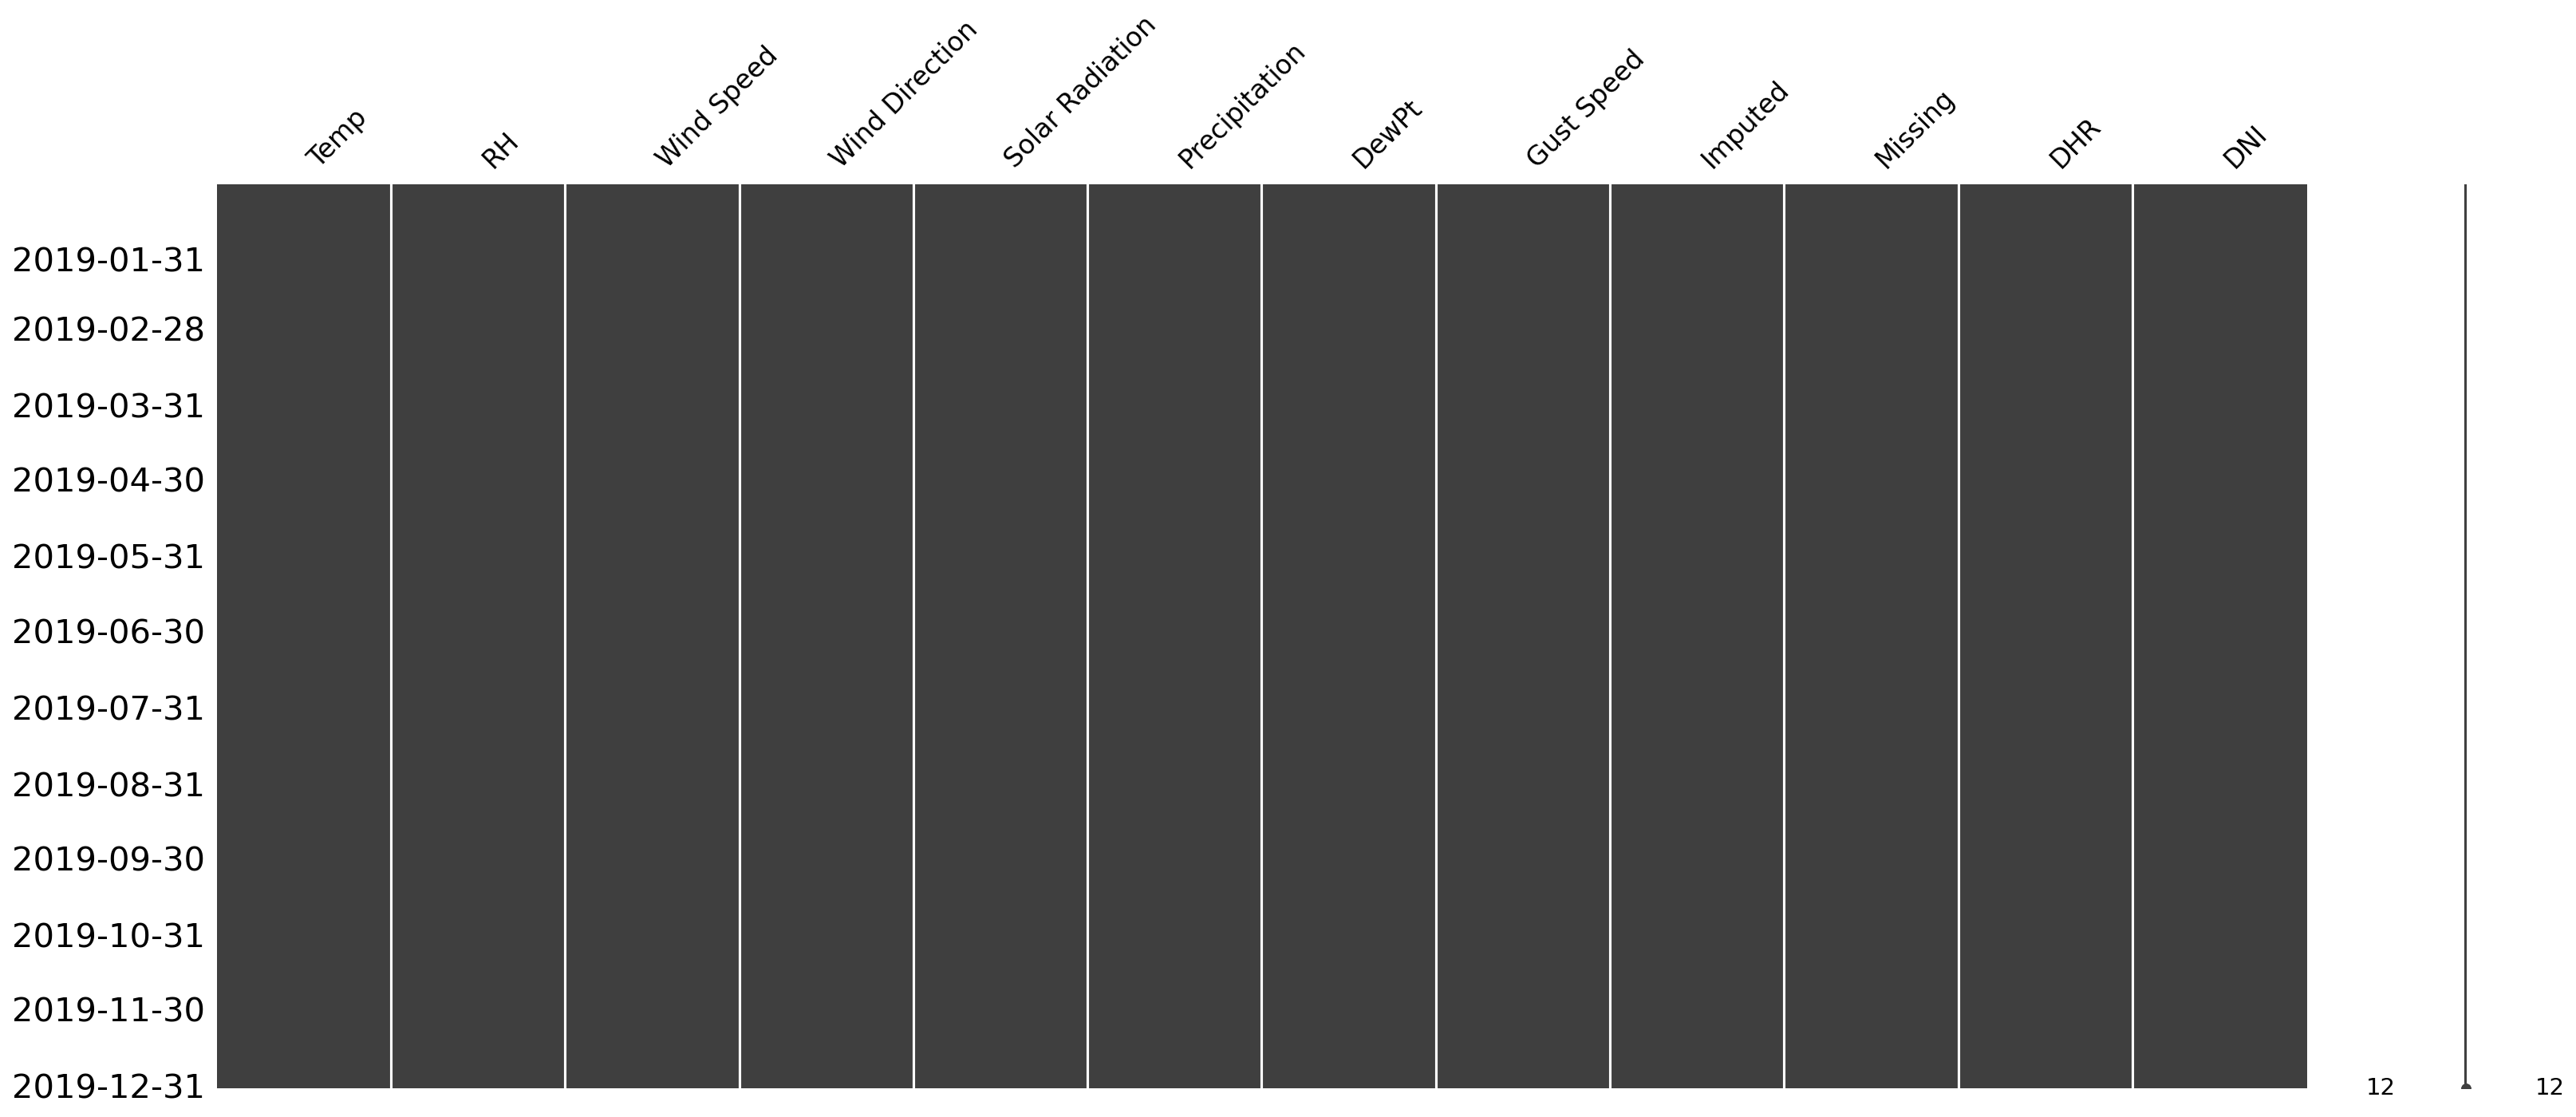

In [54]:
# GAME FARM ROAD_ITHACA STATION

#S5 = HoboReader("DL5_Game_Farm_Road_2019.csv")
#hoho_df = S5.get_dataframe()

# There are about 35 variables in the core weather data. However, not all of them are used by EnergyPlus. Actually, despite of date and time columns, only 13 columns are used:
# dry bulb temperature
# dew point temperature
# relative humidity
# atmospheric pressure
# horizontal infrared radiation intensity from sky
# direct normal radiation
# diffuse horizontal radiation
# wind direction
# wind speed
# present weather observation
# present weather codes
# snow depth
# liquid precipitation depth

# https://www.radiance-online.org/pipermail/radiance-general/2015-April/010841.html

# Daniel,

# You should be able to generate the .wea file from diffuse horizontal
# radiation and direct normal radiation values. The structure of the lines
# after the heading in .wea file is:

# month day hour directNormalRadiation diffuseHorizontalRadiation

# Load NREL 2019 and take atmospheric pressure from there
year = 2019
nrel_2019 = Path.cwd() / Path("nrel_data/1162143_42.45_-76.50_2019.csv")
# print(nrel_2019)
nrel_2019_df = pd.read_csv(nrel_2019)
#df.columns = df.index[0]
nrel_2019_df.columns = nrel_2019_df.loc[nrel_2019_df.index[1]]
nrel_2019_df = nrel_2019_df.drop(nrel_2019_df.index[0])
nrel_2019_df = nrel_2019_df.drop(nrel_2019_df.index[0])

nrel_2019_pressure = nrel_2019_df['Pressure'].astype(int) * 100

# Real file

# e.headers['LOCATION'][0]='Ithaca_NY'

# Design conditions and extreme periods are taken from the Syracuse file

make_epw("GameFarmRoad", 2019,df5, False)

2019 DL1
2019 DL2
2019 DL3


C:\Users\pkastner\Anaconda3\envs\hobo\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning: invalid value encountered in calc_split (vectorized)
  outputs = ufunc(*inputs)


2019 DL4
2019 DL5
2020 DL1
2020 DL2
2020 DL3
2020 DL4
2020 DL5


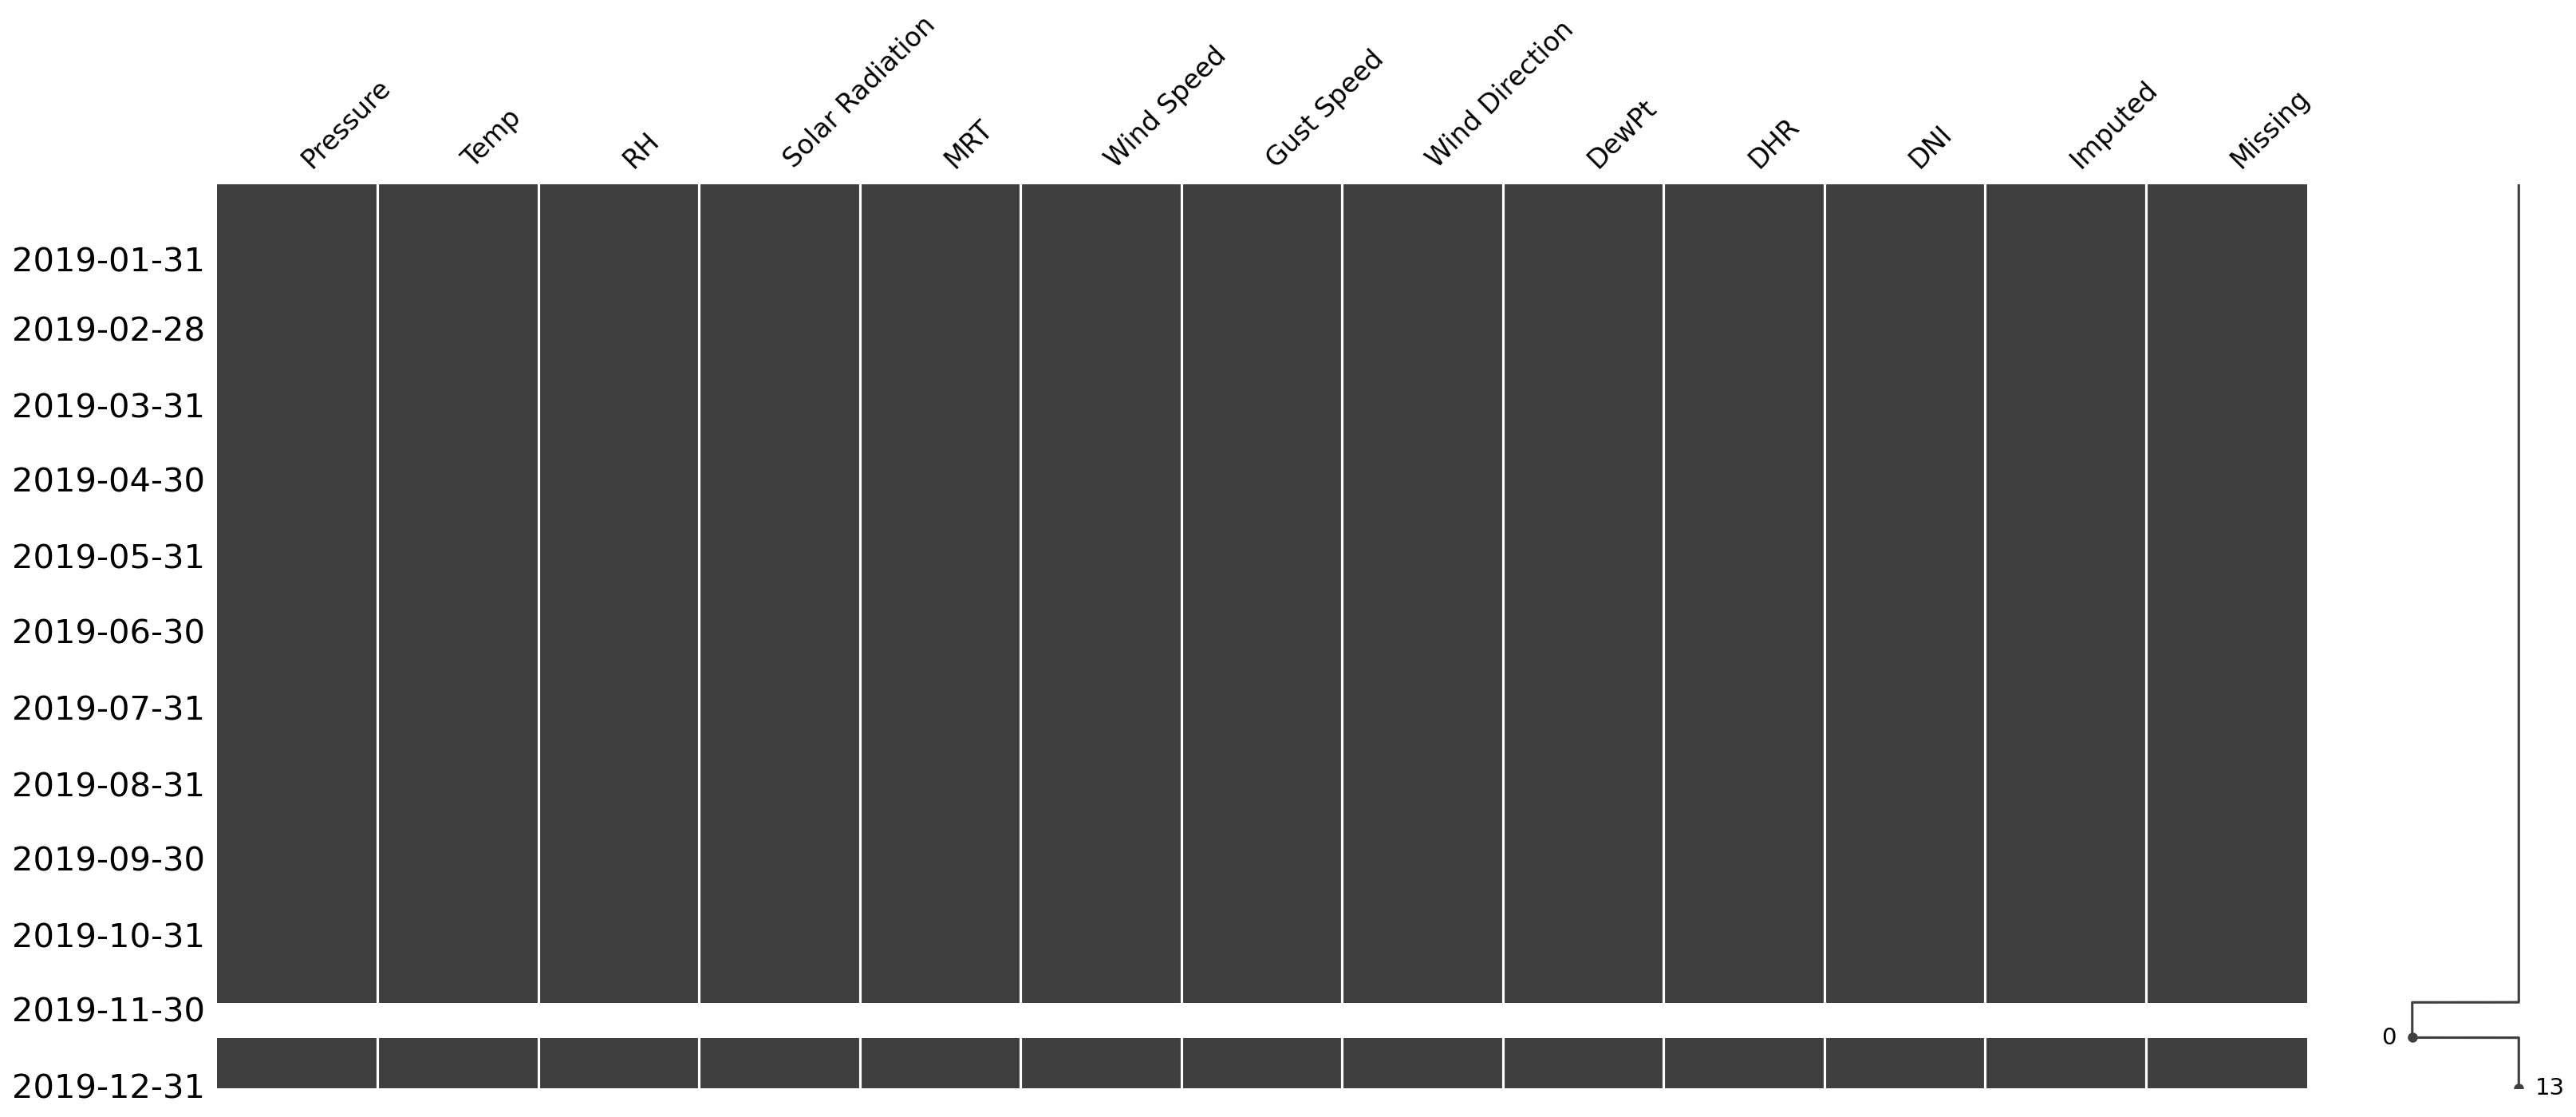

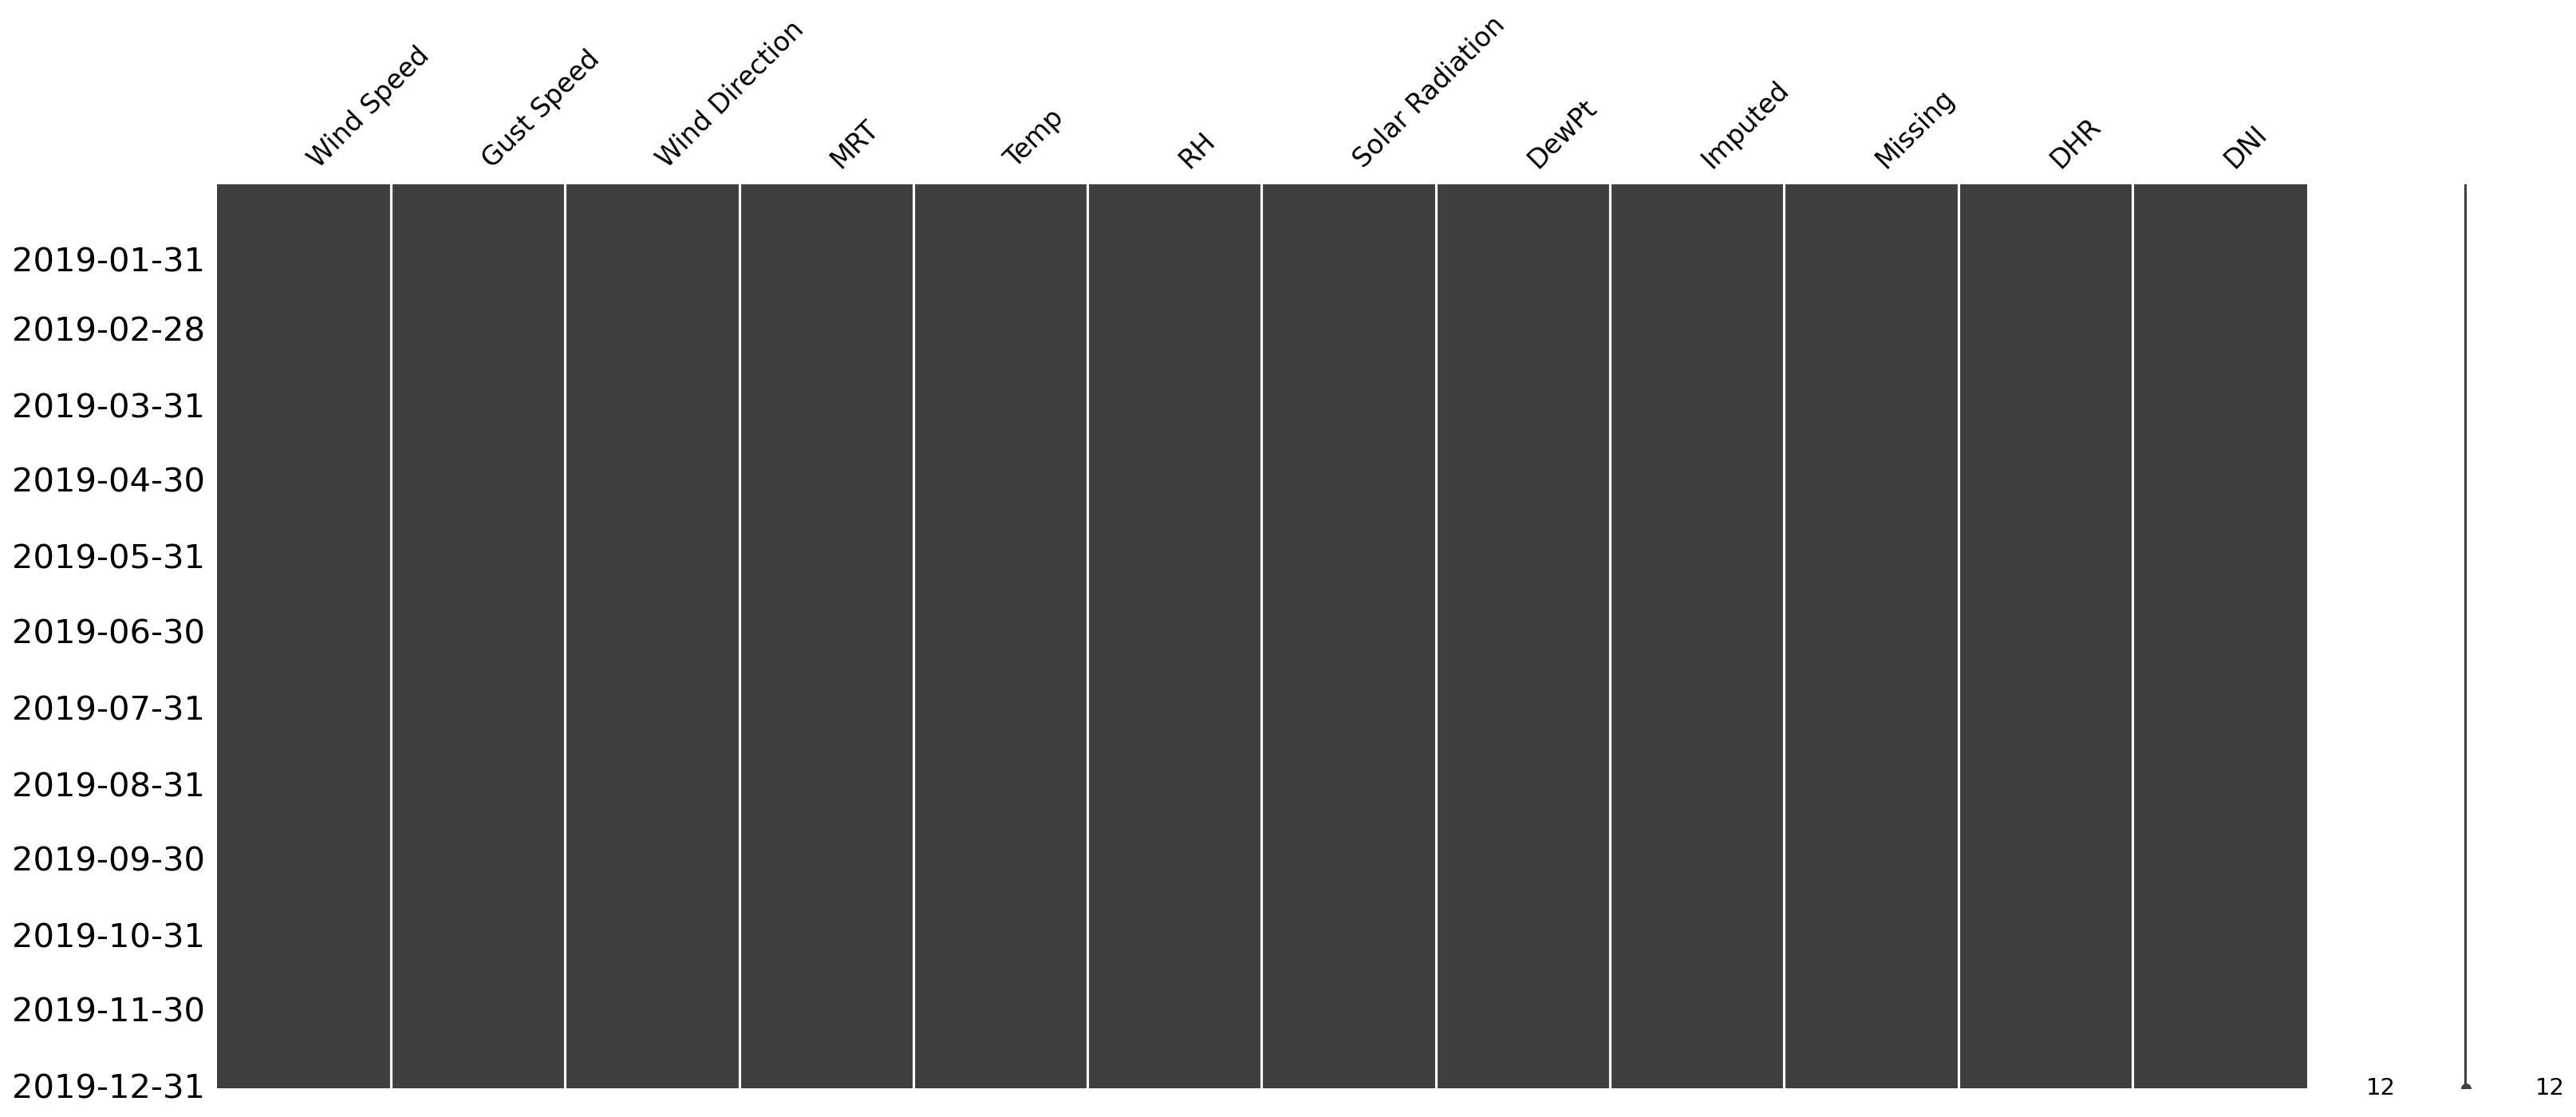

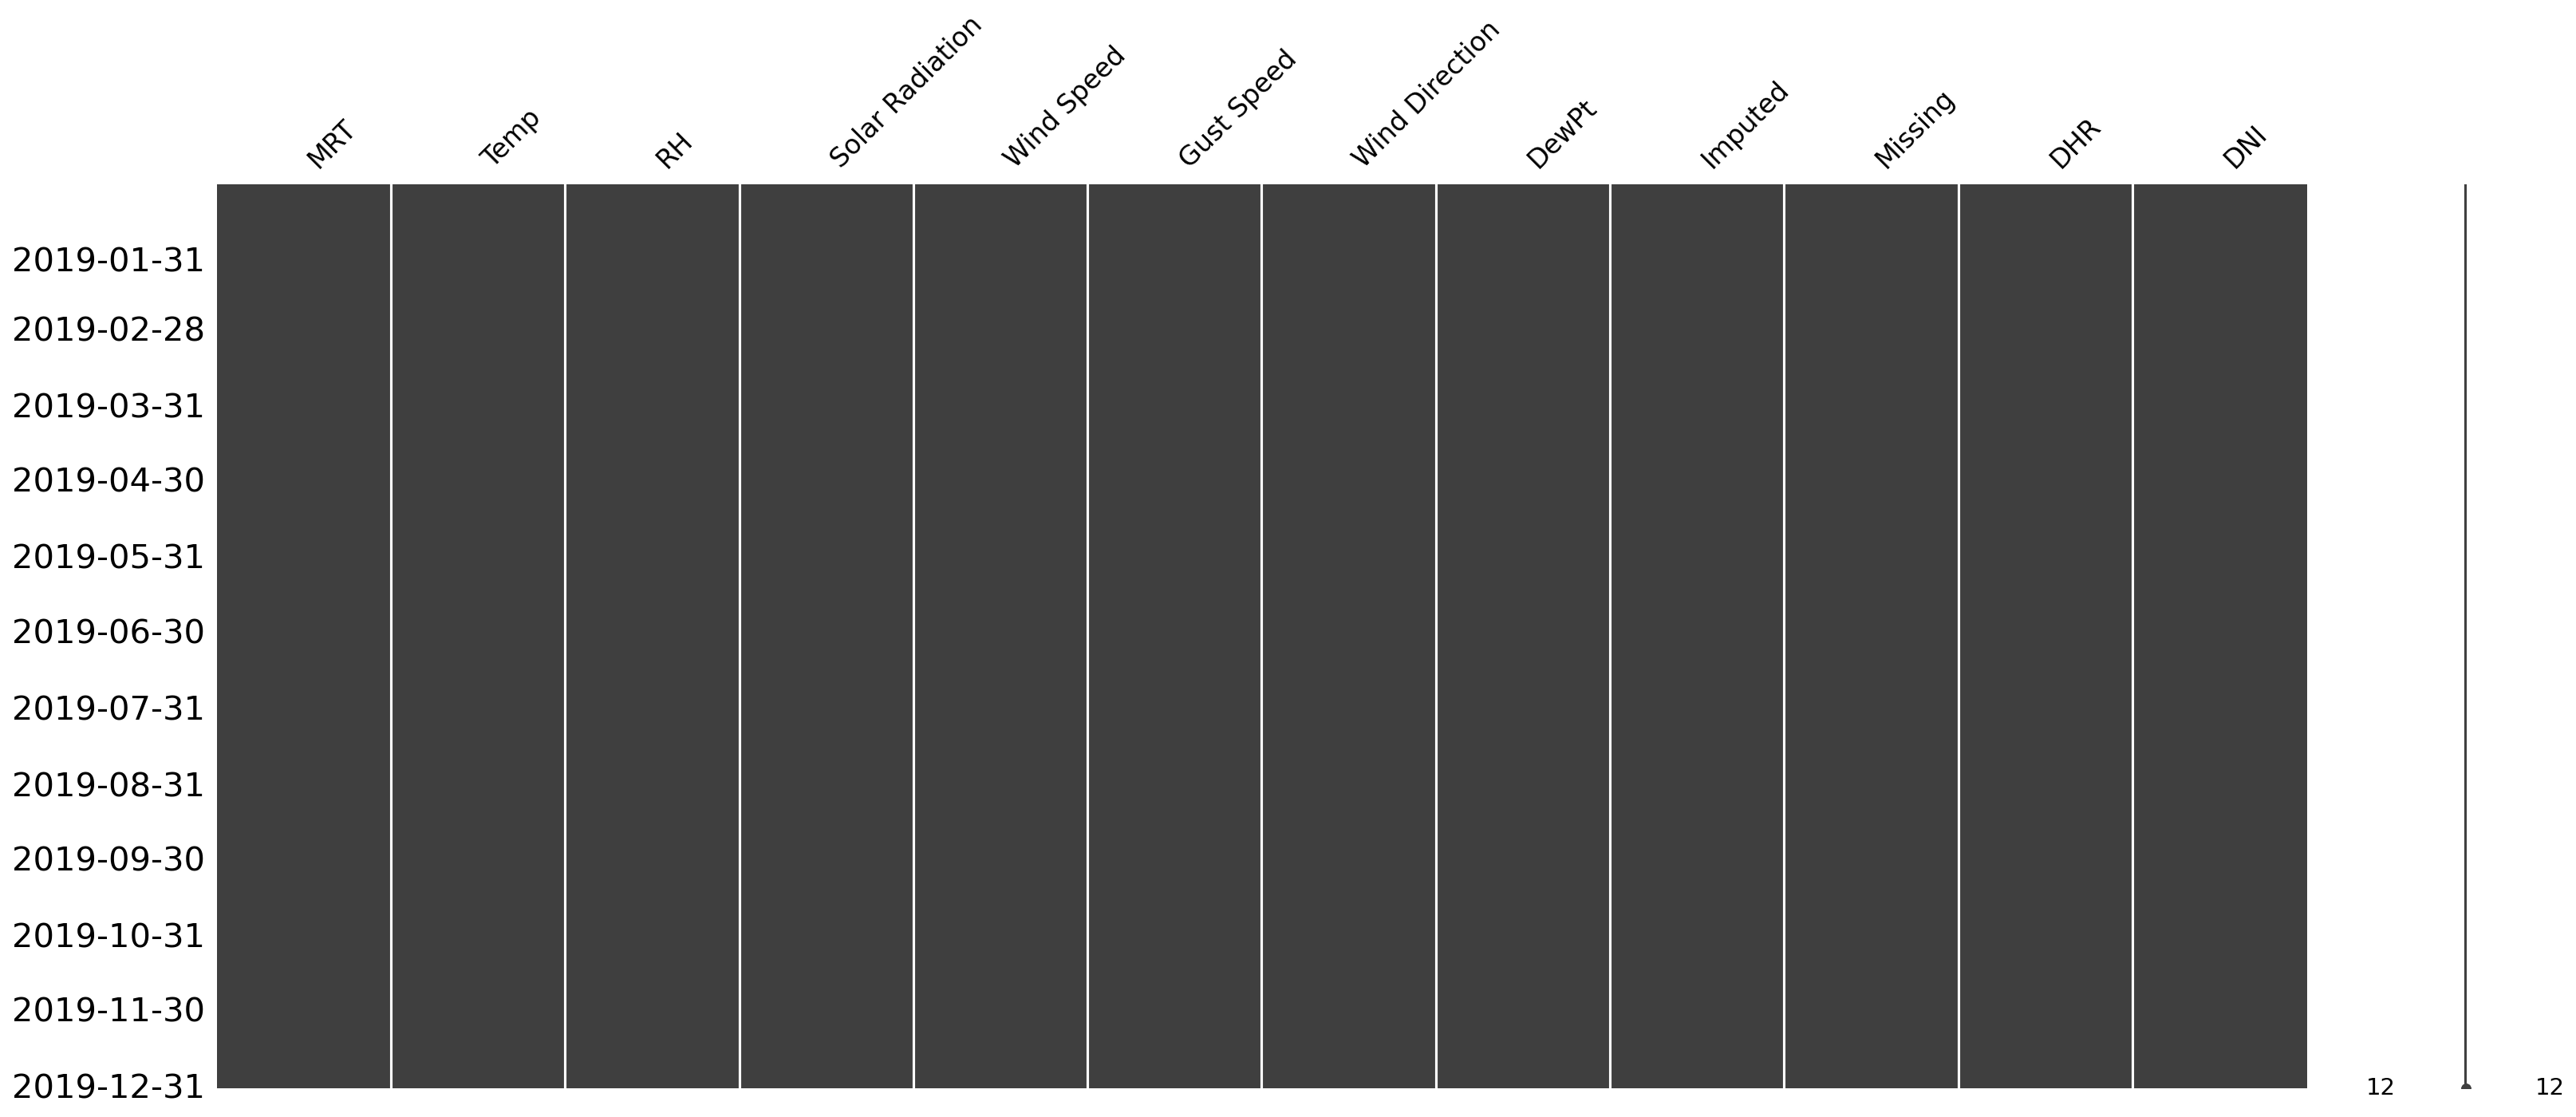

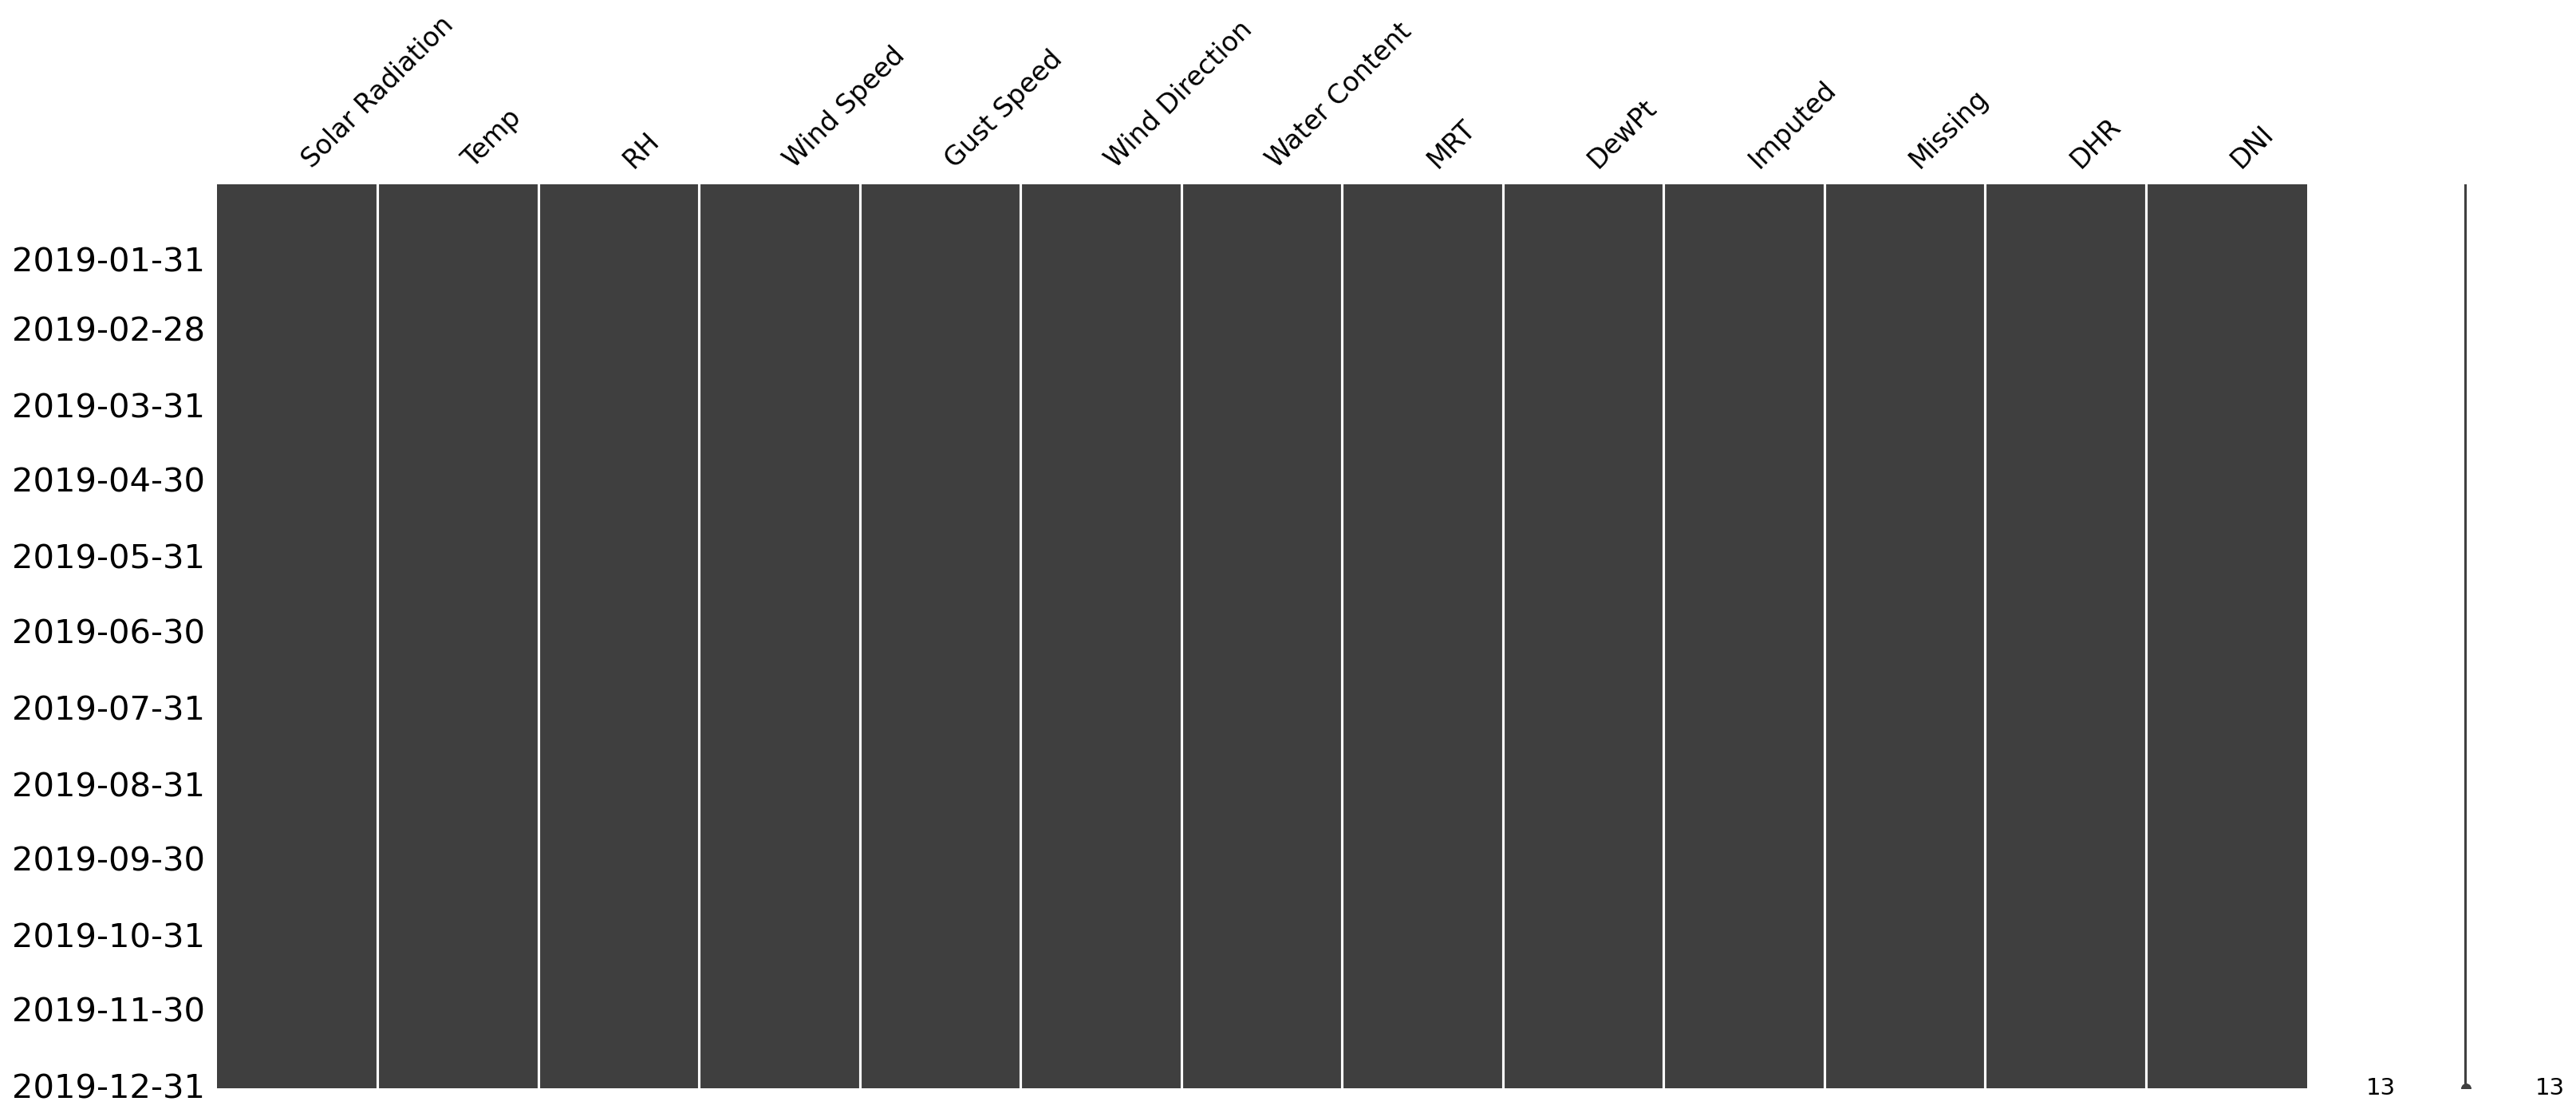

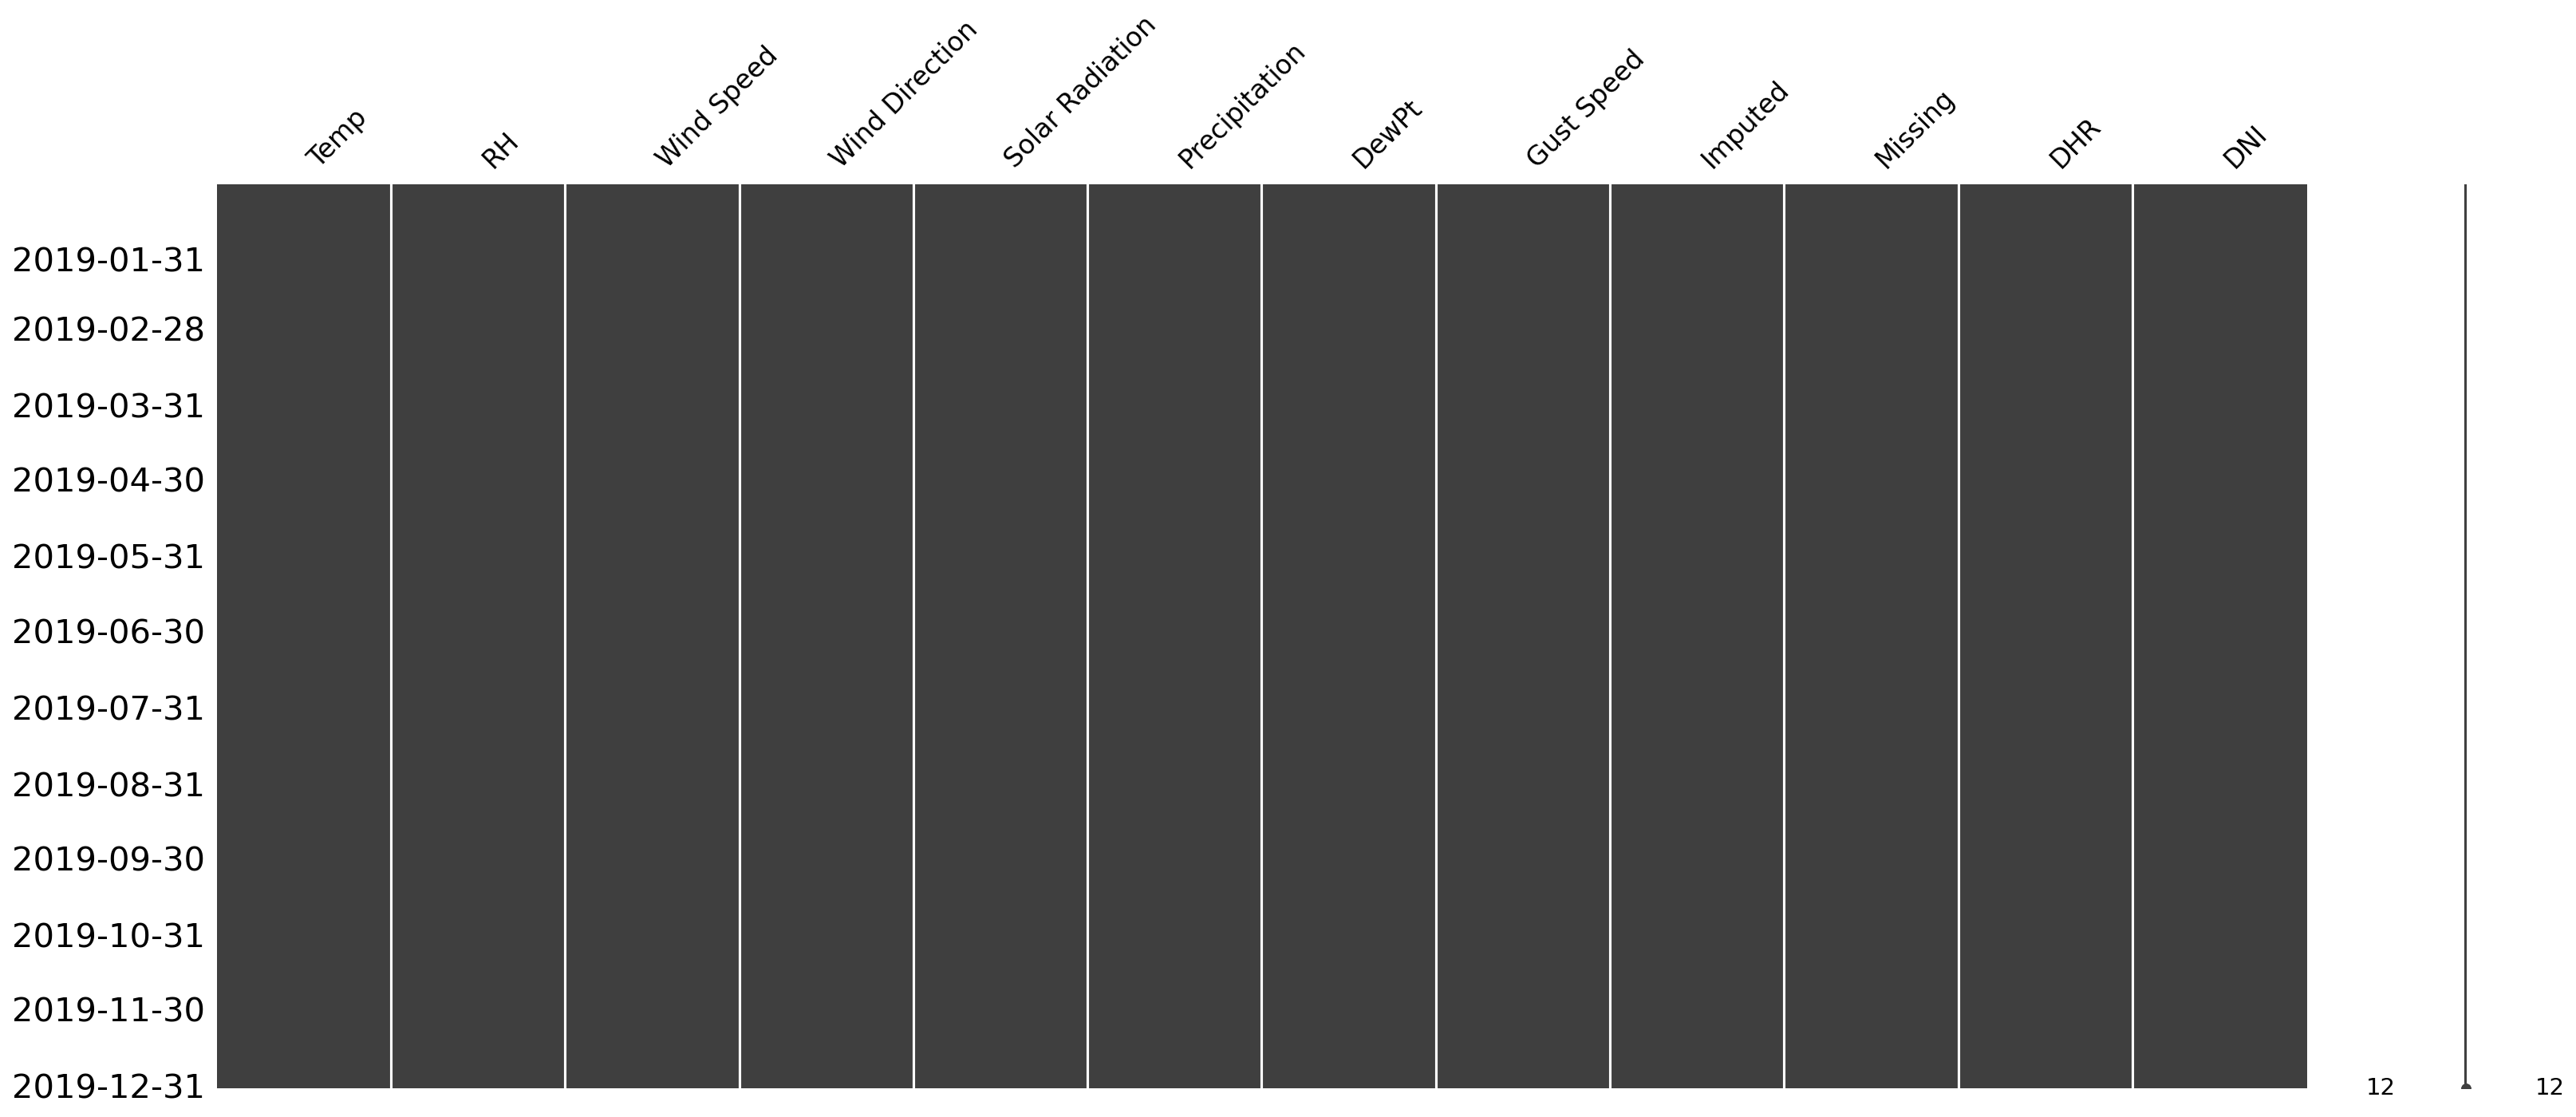

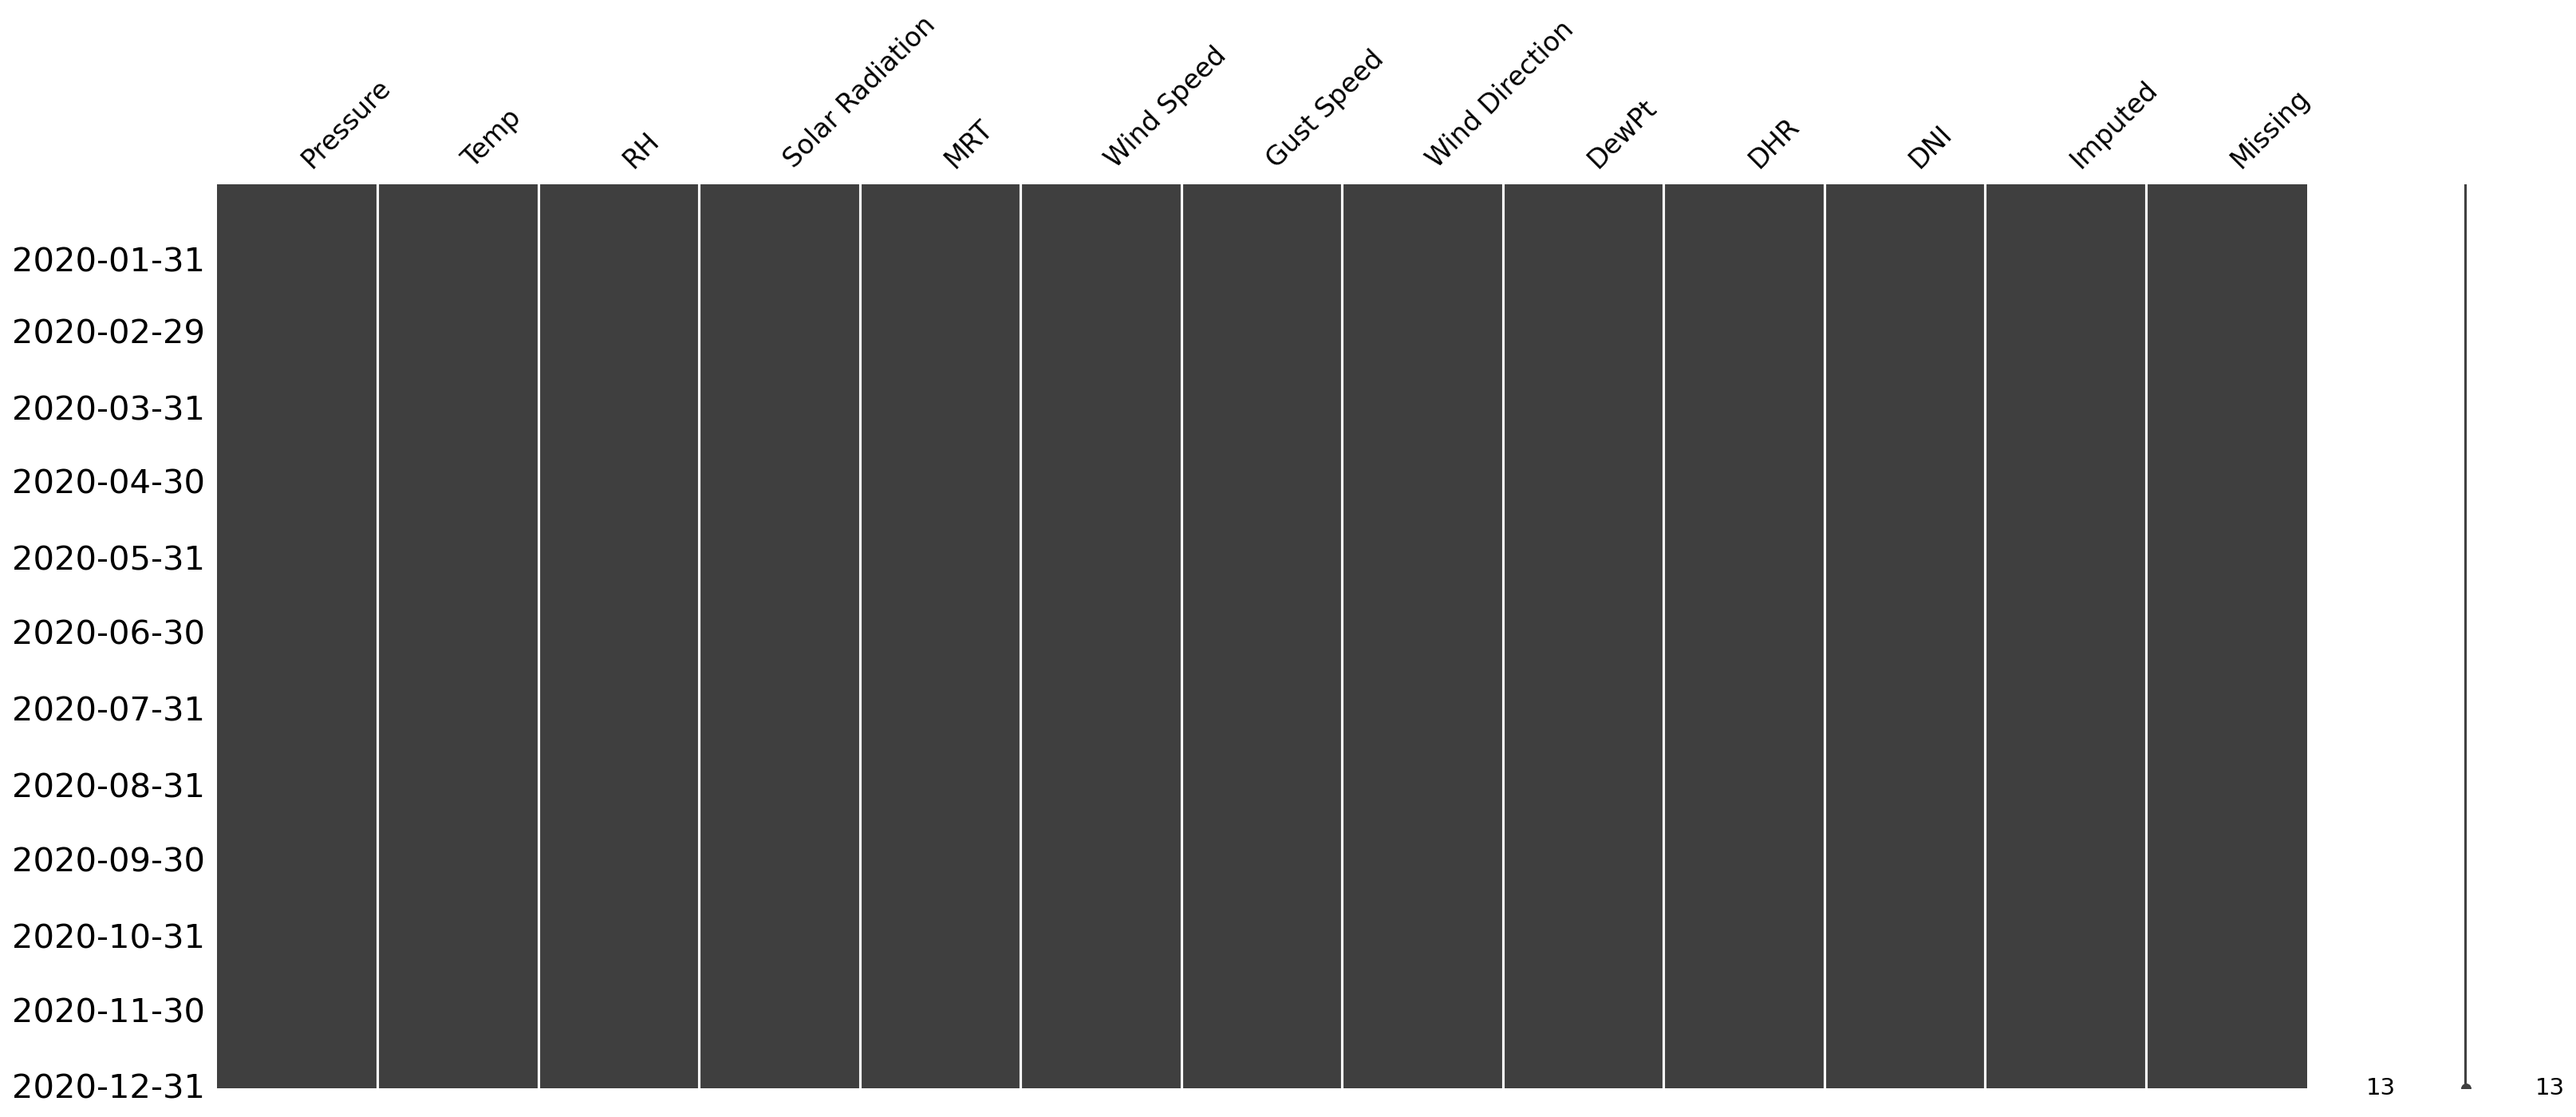

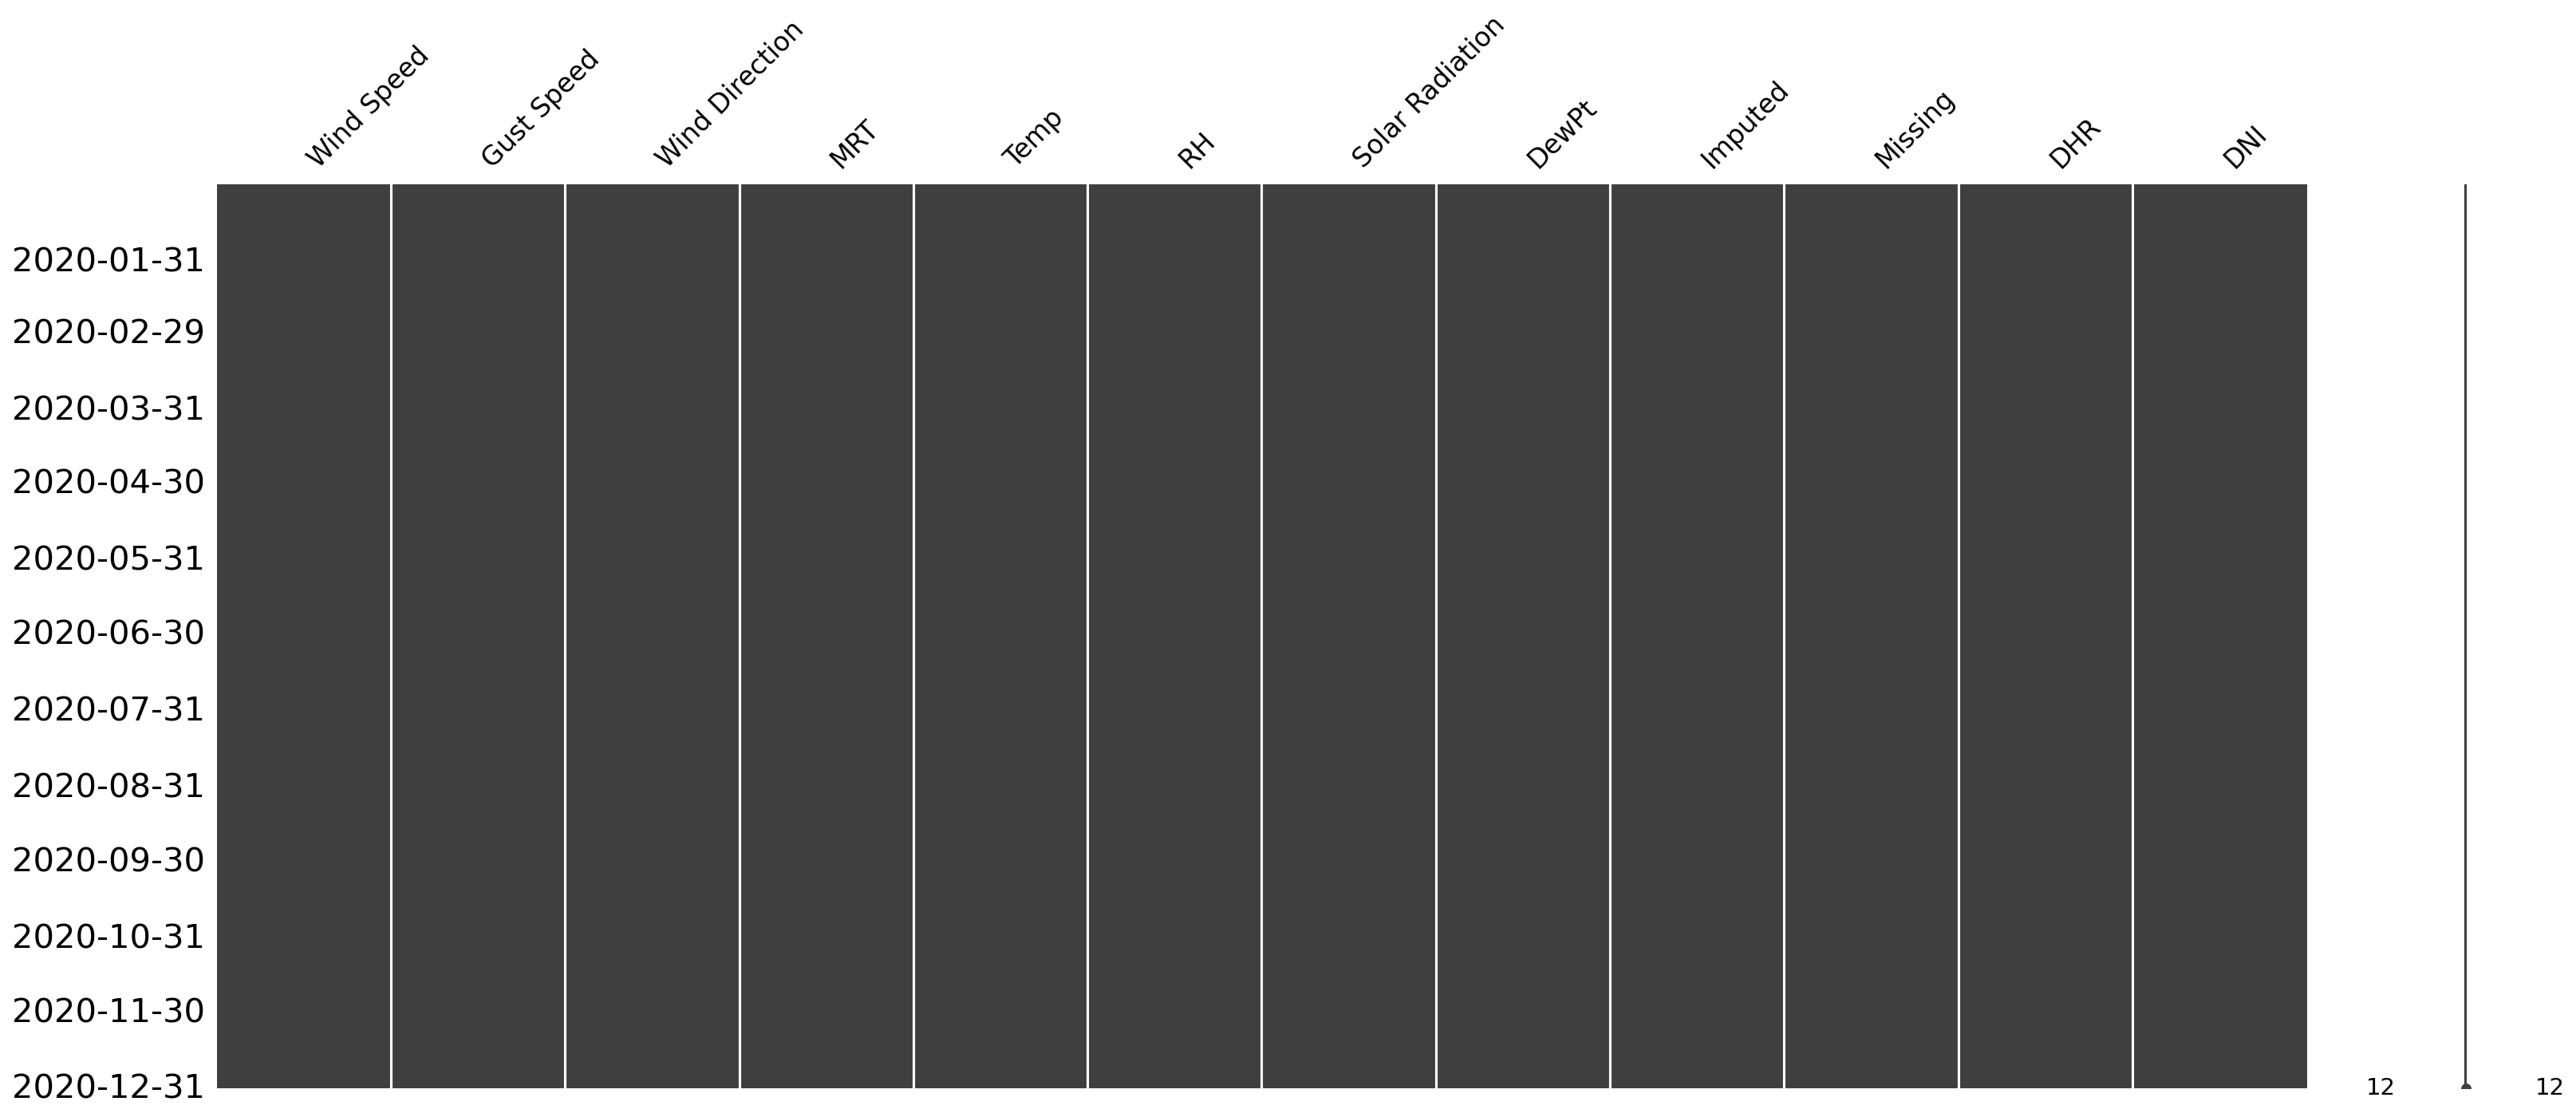

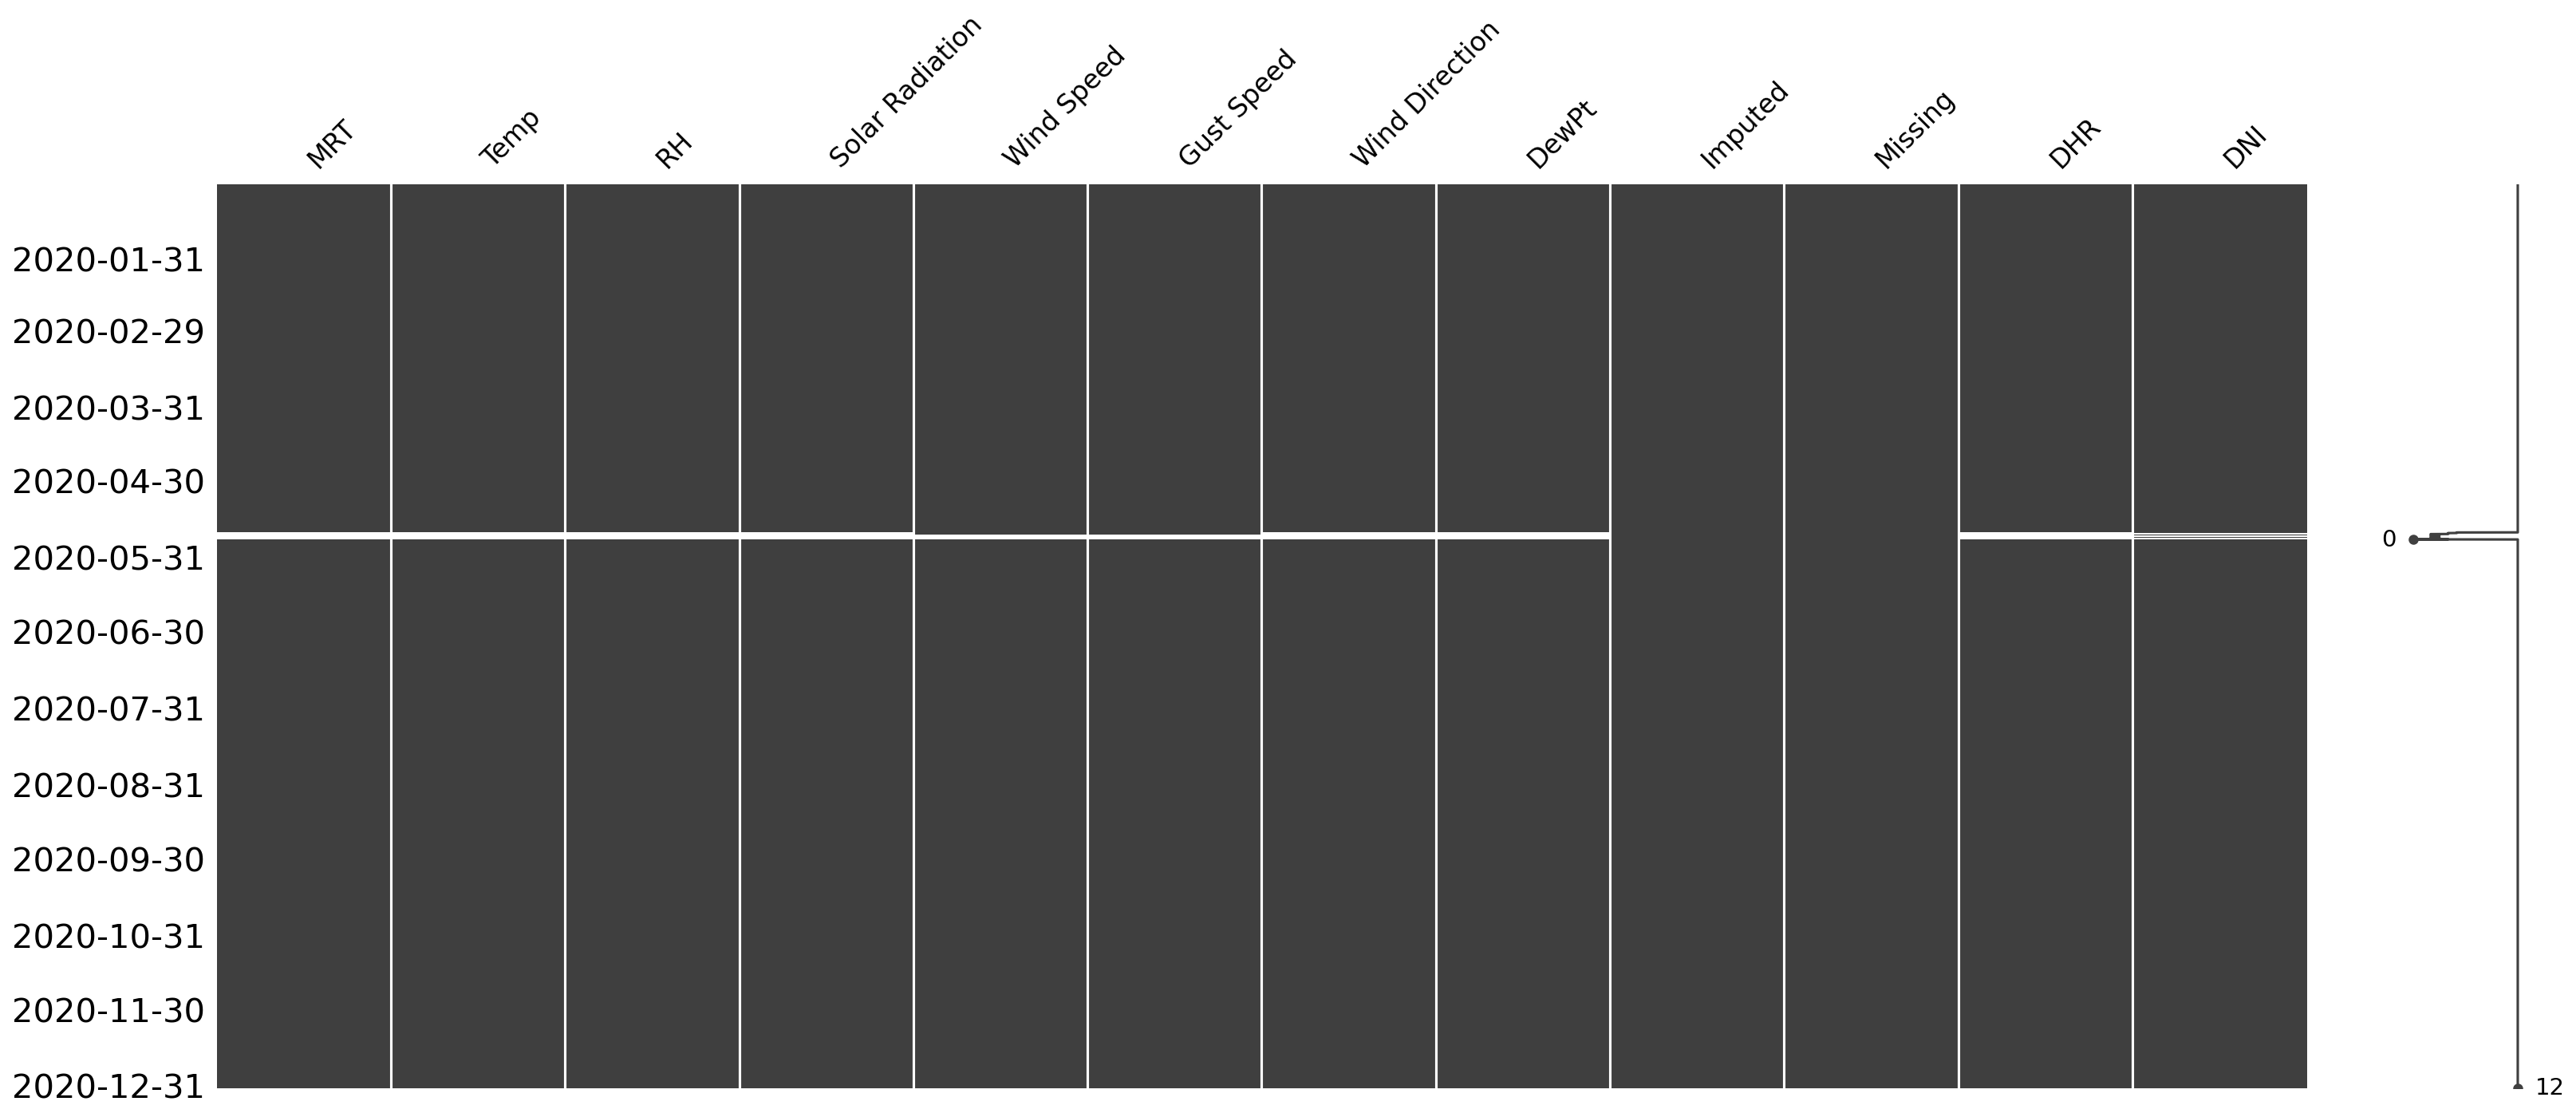

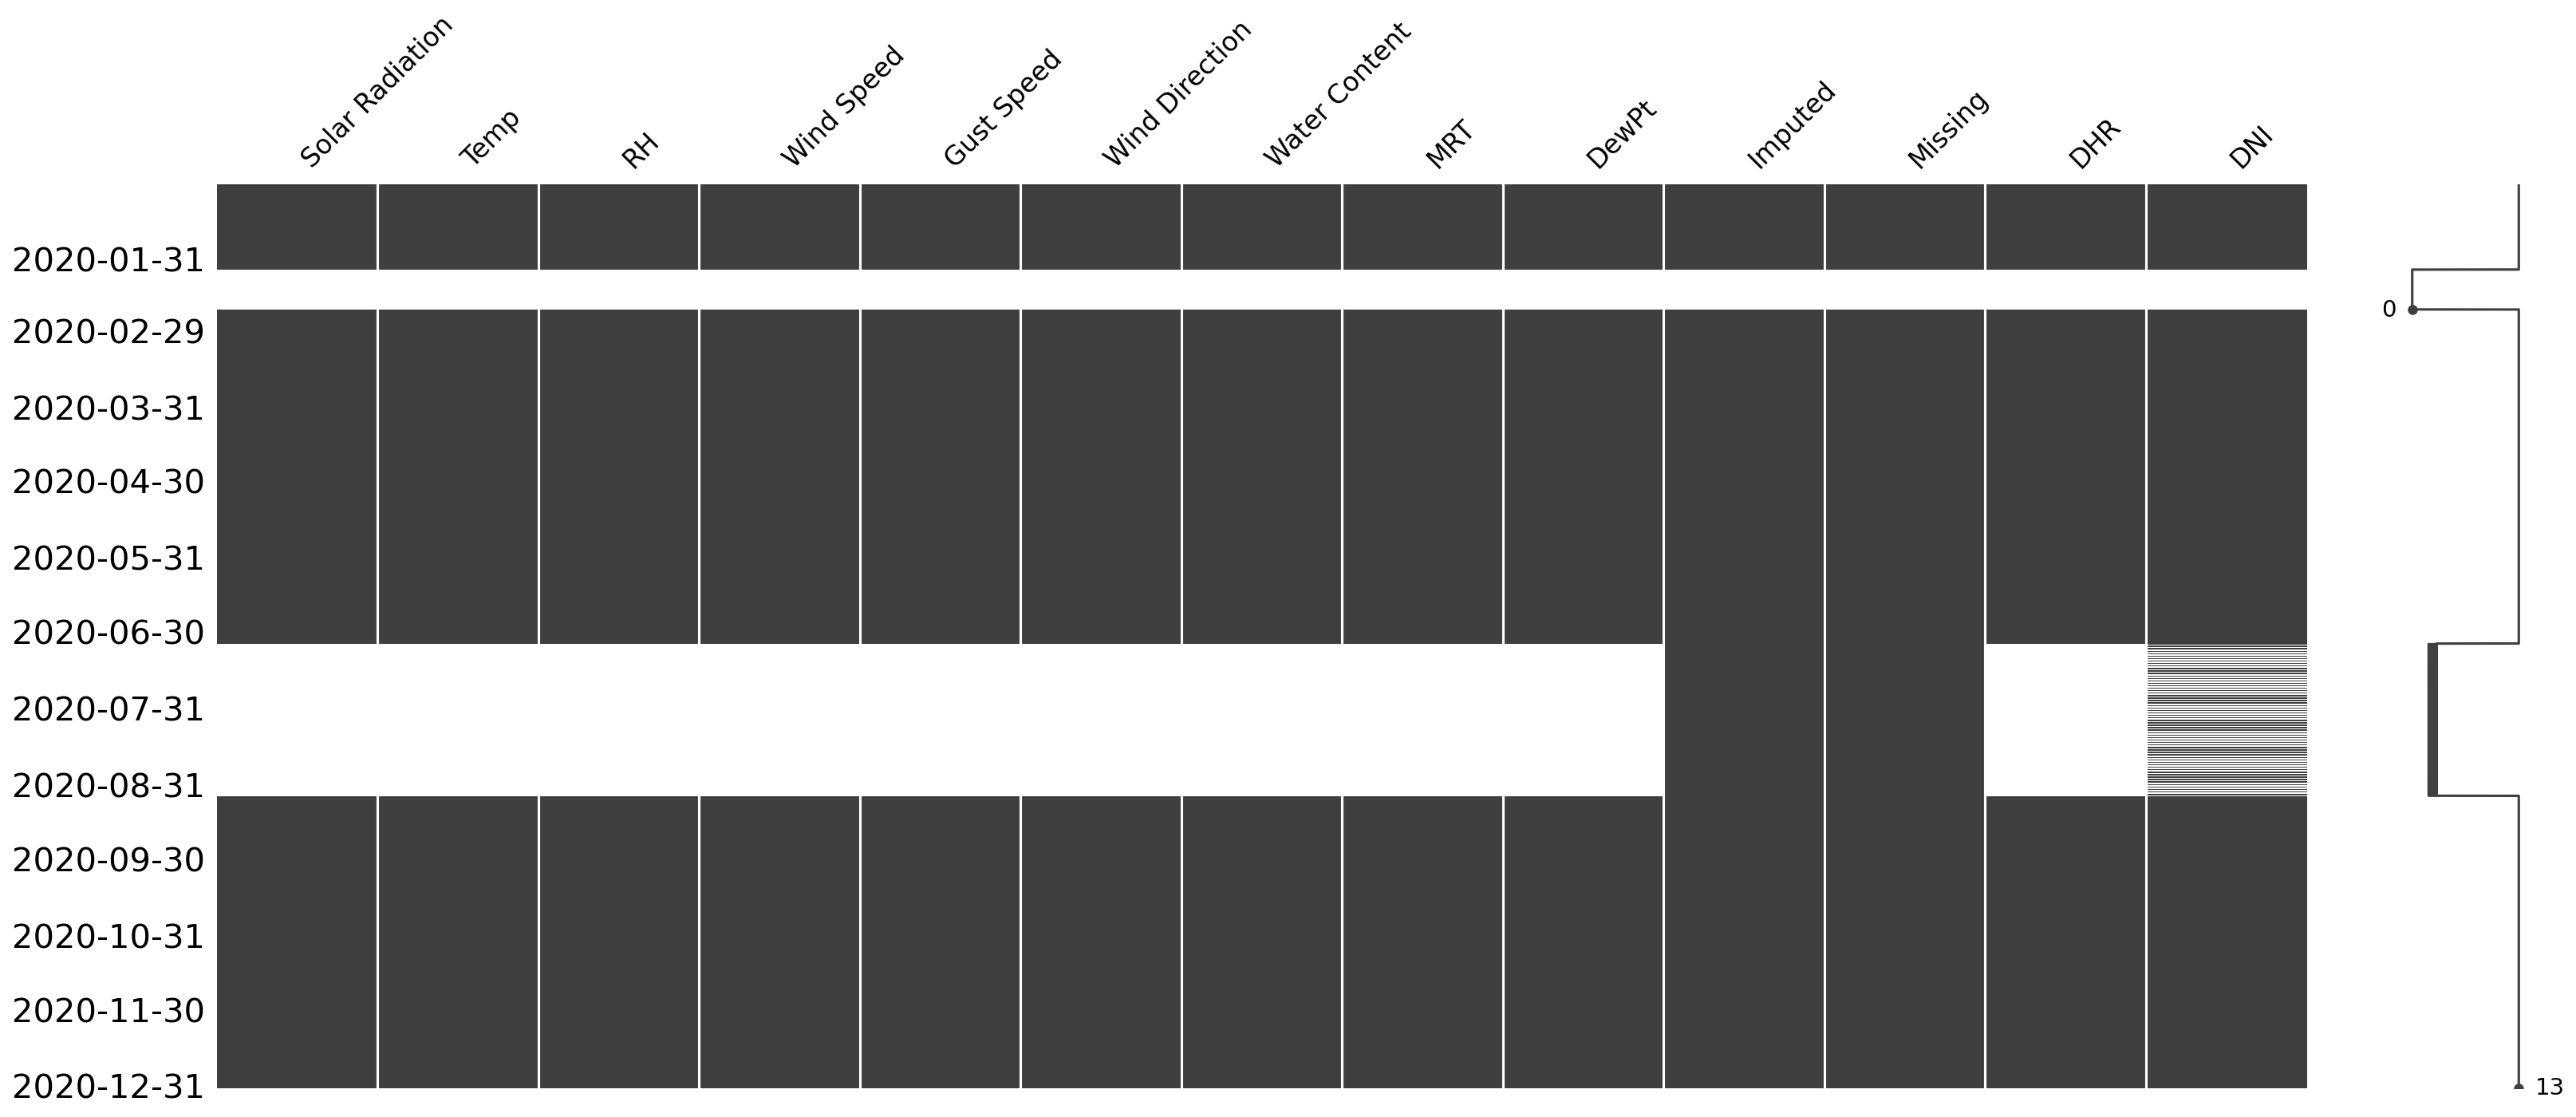

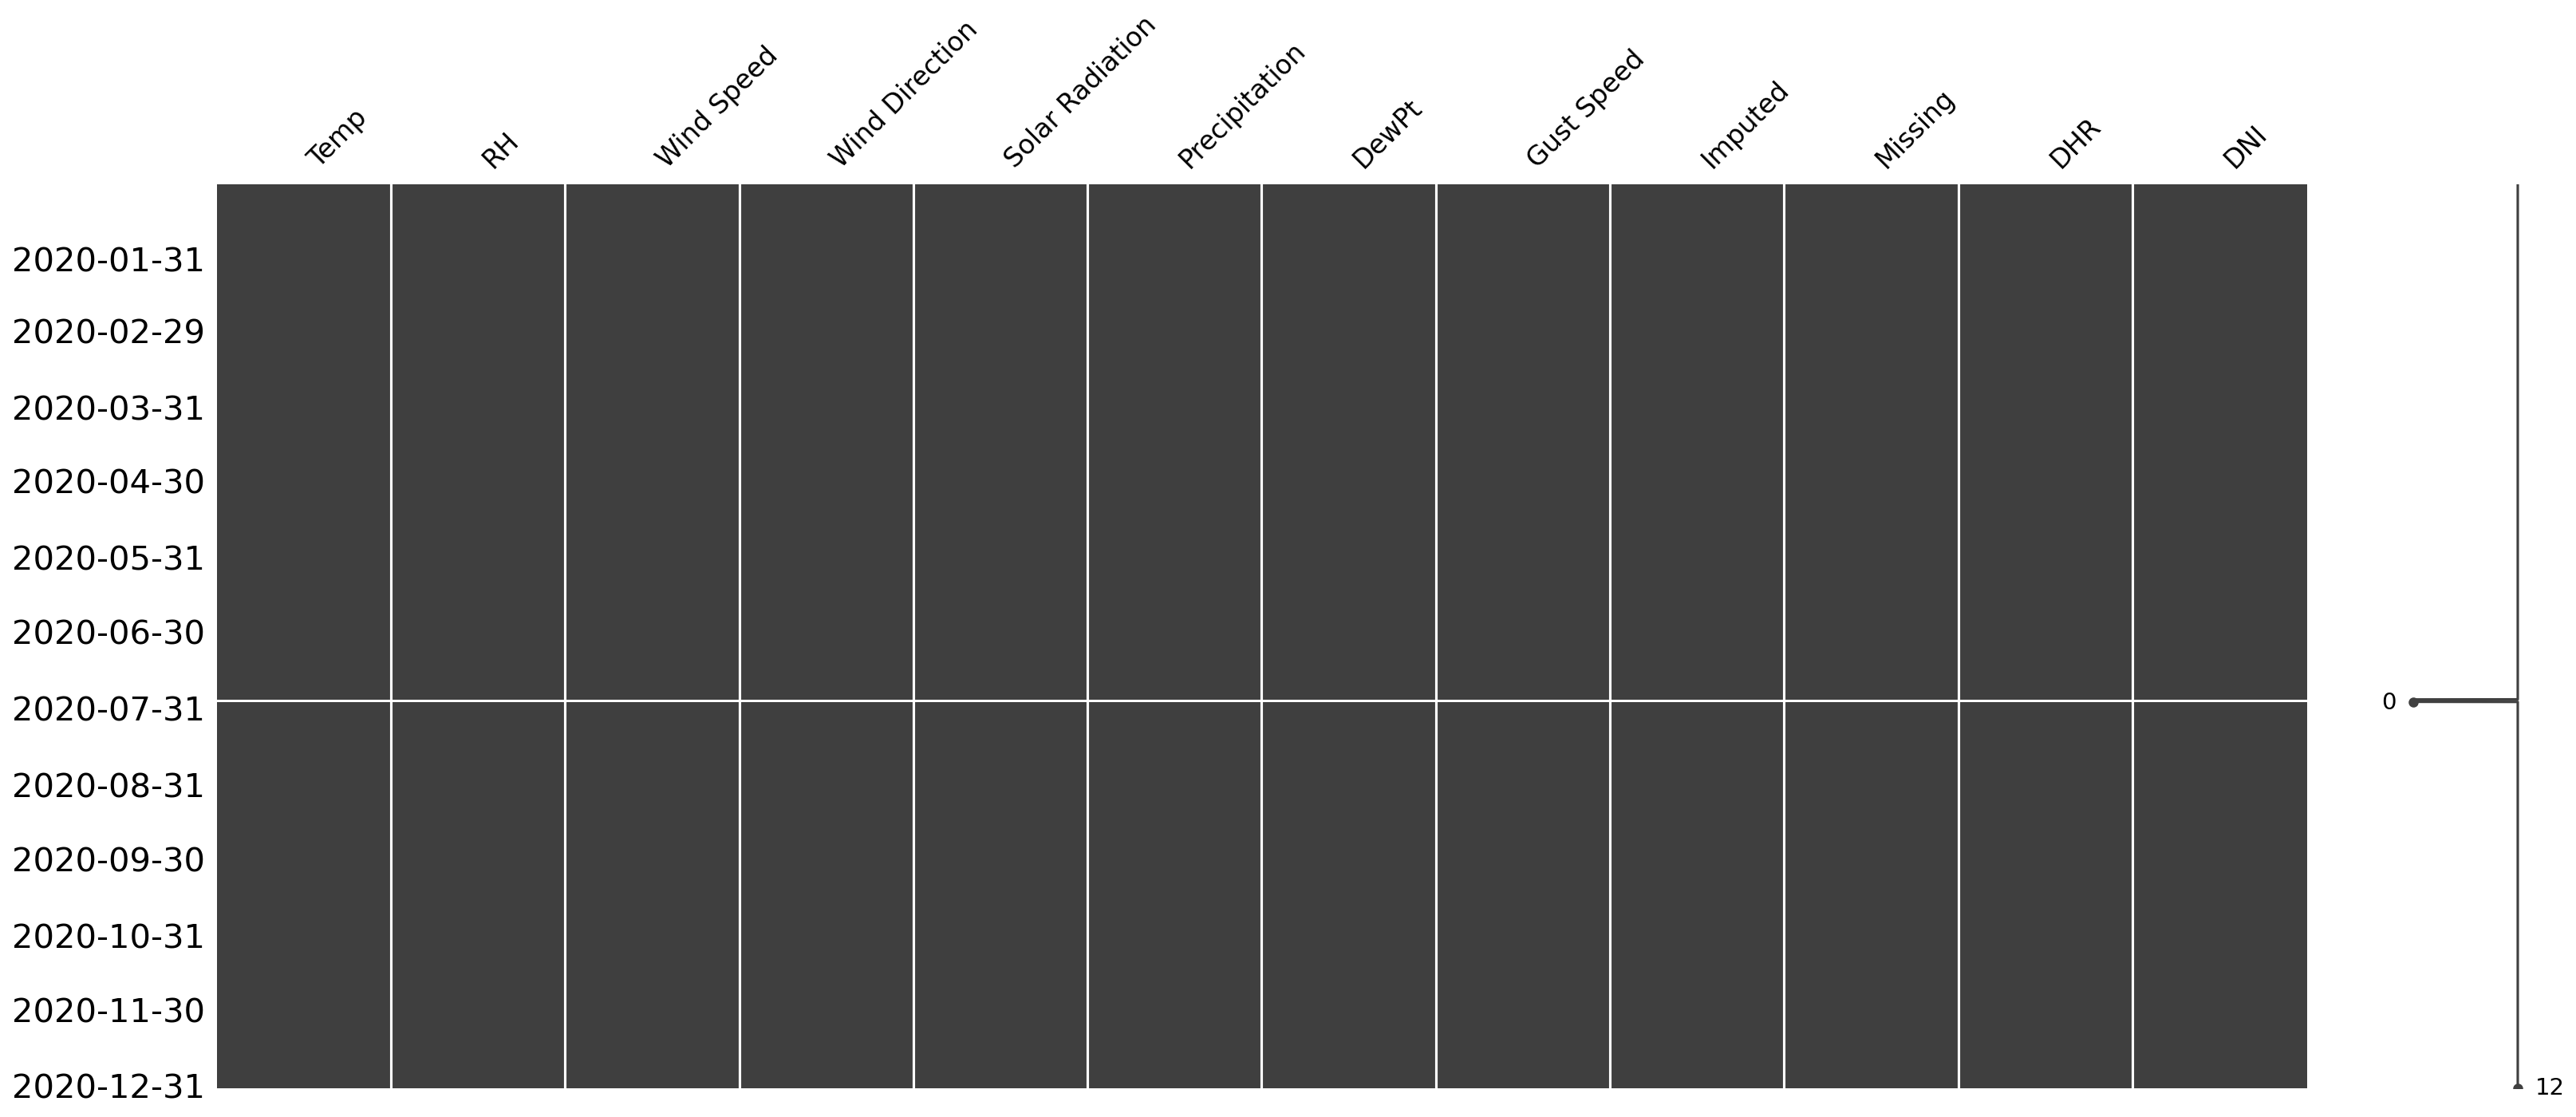

In [55]:
# All to EPW
year = [2019, 2020]

#names = ["DL1_Stone_Garden_Tjaden_Hall.csv","DL2_PSB_Parking_Lot.csv","DL3_Olin_Library.csv","DL4_Milstein_Hall_Roof.csv", "DL5_Game_Farm_Road.csv"]

stations = {'DL1': df1, 'DL2': df2, 'DL3': df3, 'DL4': df4, 'DL5': df5}

ul = list(itertools.product(year, stations))

for y, s in ul:
    print(y, s)
    make_epw(s, y, stations[s], False)

Leap year day removed.
Leap year day removed.


C:\Users\pkastner\Anaconda3\envs\hobo\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning: invalid value encountered in calc_split (vectorized)
  outputs = ufunc(*inputs)


Leap year day removed.
Leap year day removed.
Leap year day removed.
Leap year day removed.


,Year,Month,Day,Hour,Minute,Data Source and Uncertainty Flags,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Station Pressure,...,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snowfall,Albedo,Liquid Precipitation Depth,Liquid Precipitation Quantity
0,2020,1,1,1,0,999.0,-1.5,-5.522505,74.0,955.93,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
1,2020,1,1,2,0,999.0,-1.5,-5.522505,74.0,956.43,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
2,2020,1,1,3,0,999.0,-1.7,-5.210706,76.9,956.63,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
3,2020,1,1,4,0,999.0,-1.8,-4.986211,78.8,956.80,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
4,2020,1,1,5,0,999.0,-2.1,-5.194903,79.3,956.97,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,2020,12,31,20,0,999.0,-0.8,-4.953659,73.4,980.50,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
8780,2020,12,31,21,0,999.0,-0.8,-4.971648,73.3,981.04,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
8781,2020,12,31,22,0,999.0,-0.8,-4.971648,73.3,981.91,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
8782,2020,12,31,23,0,999.0,-0.8,-4.810523,74.2,982.27,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0


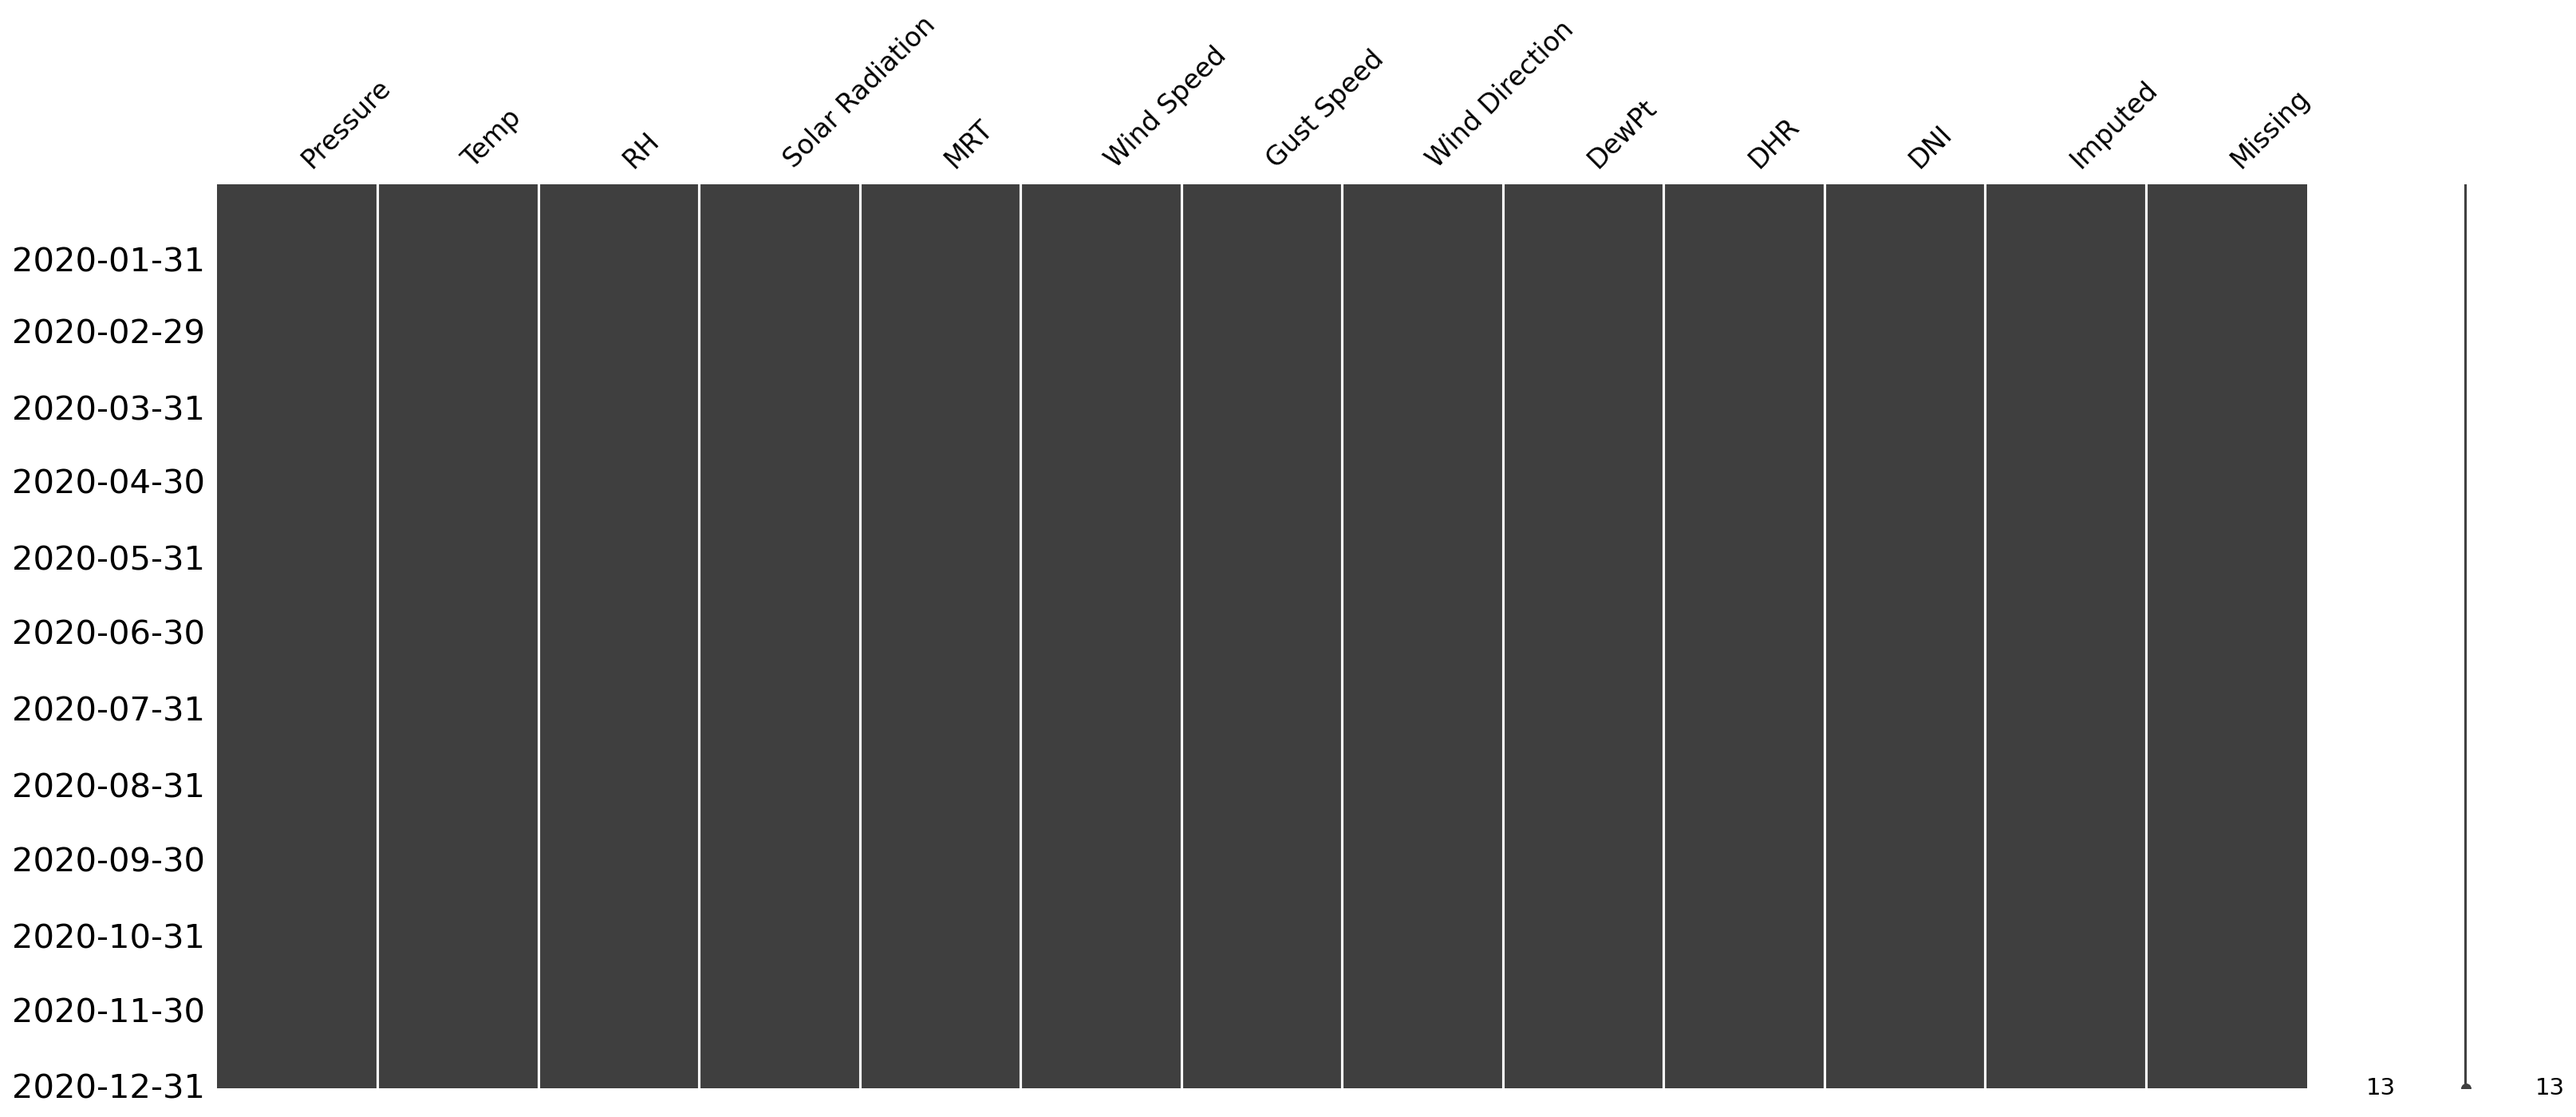

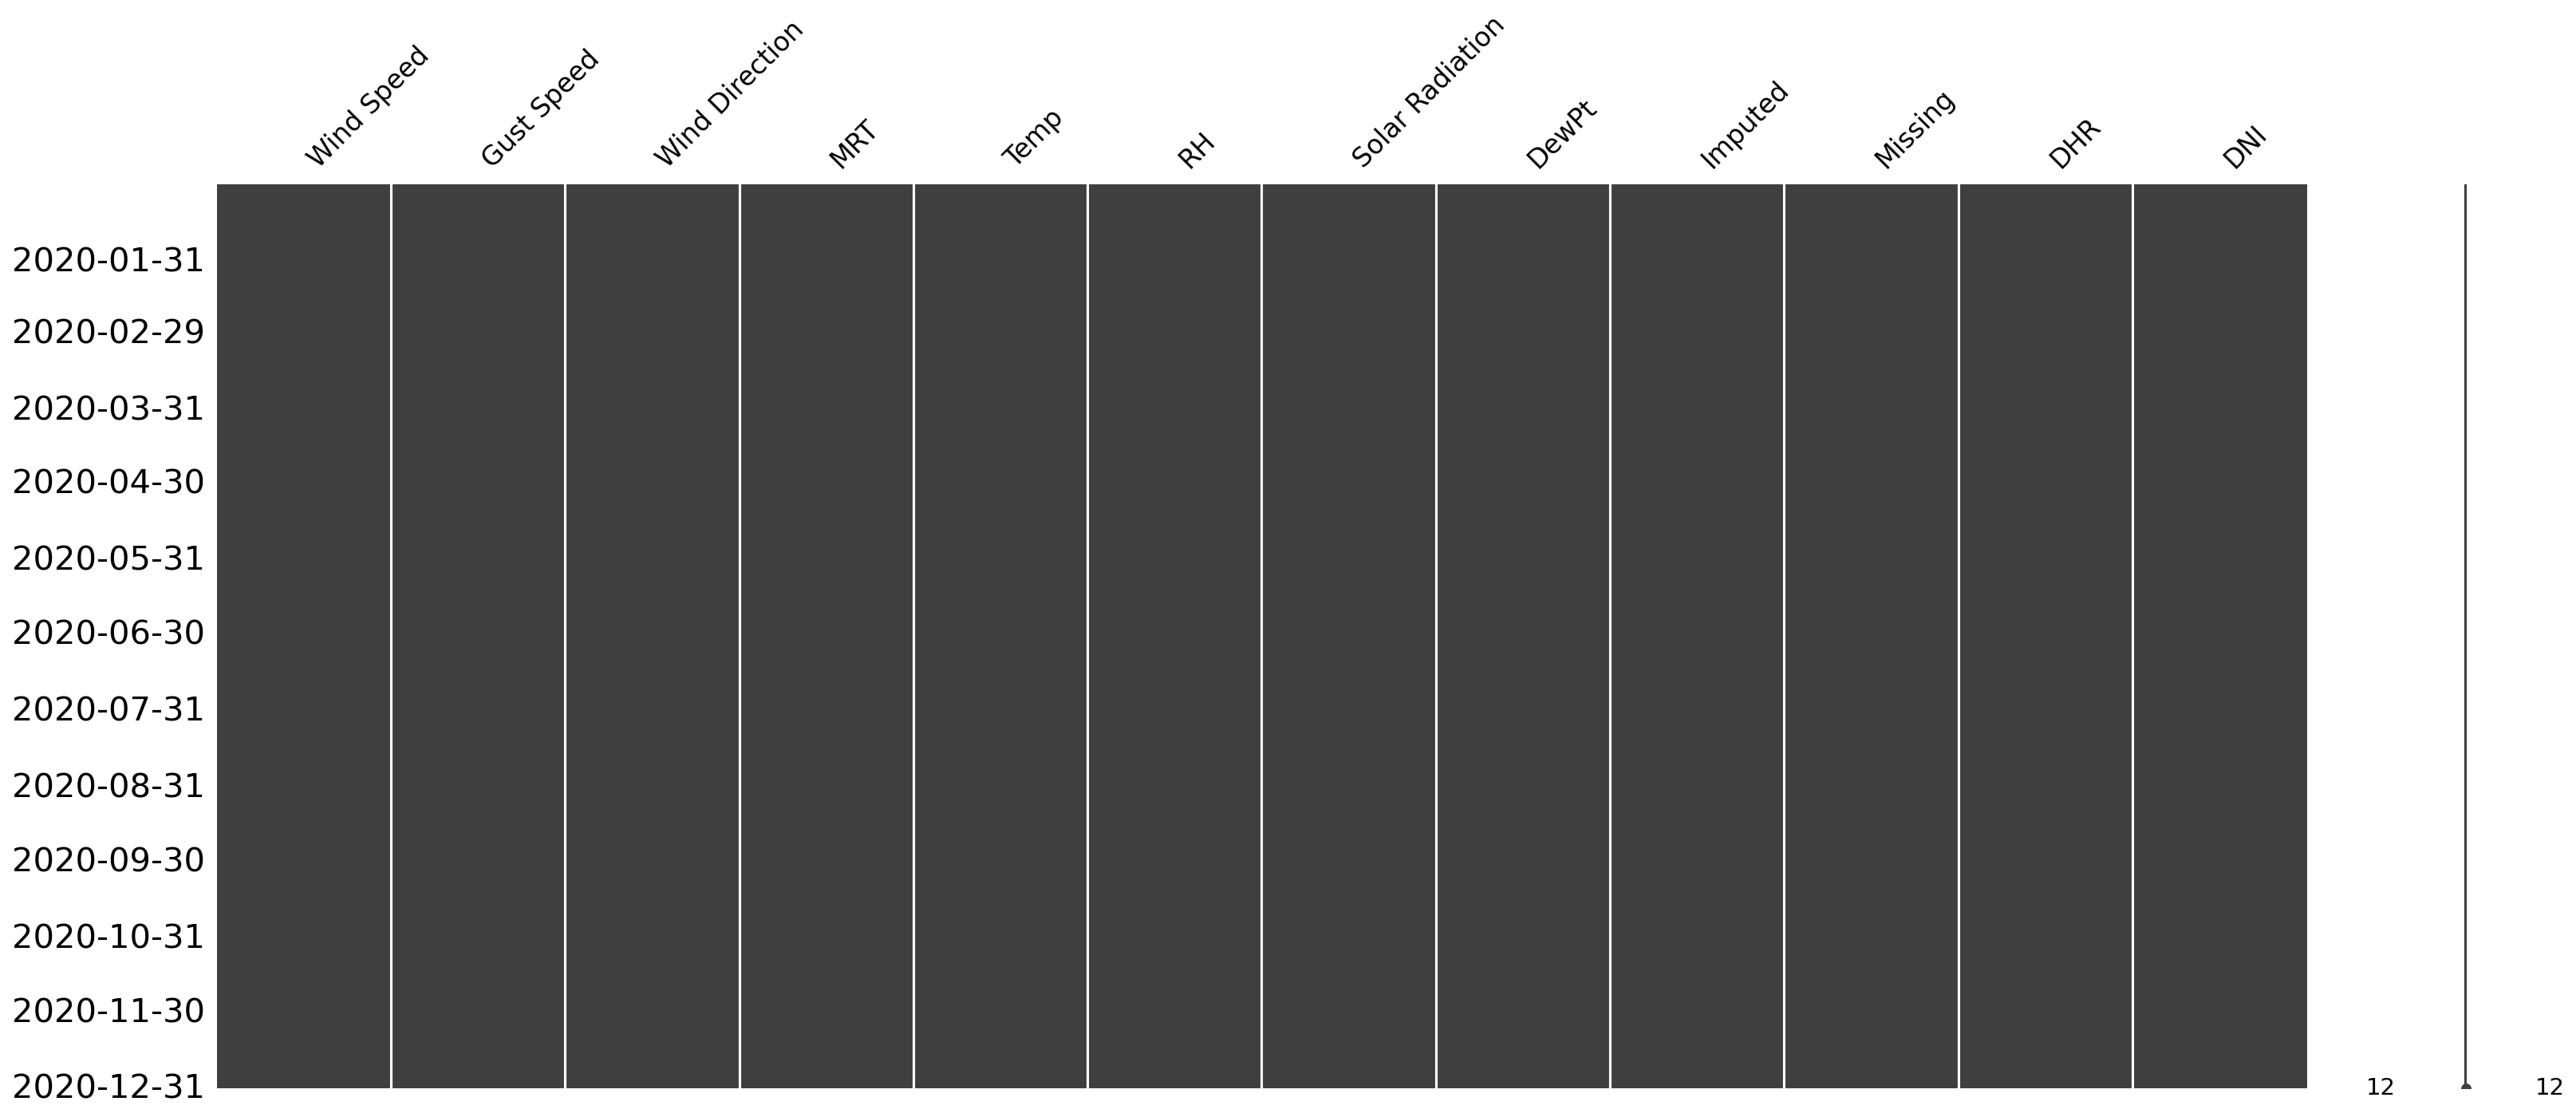

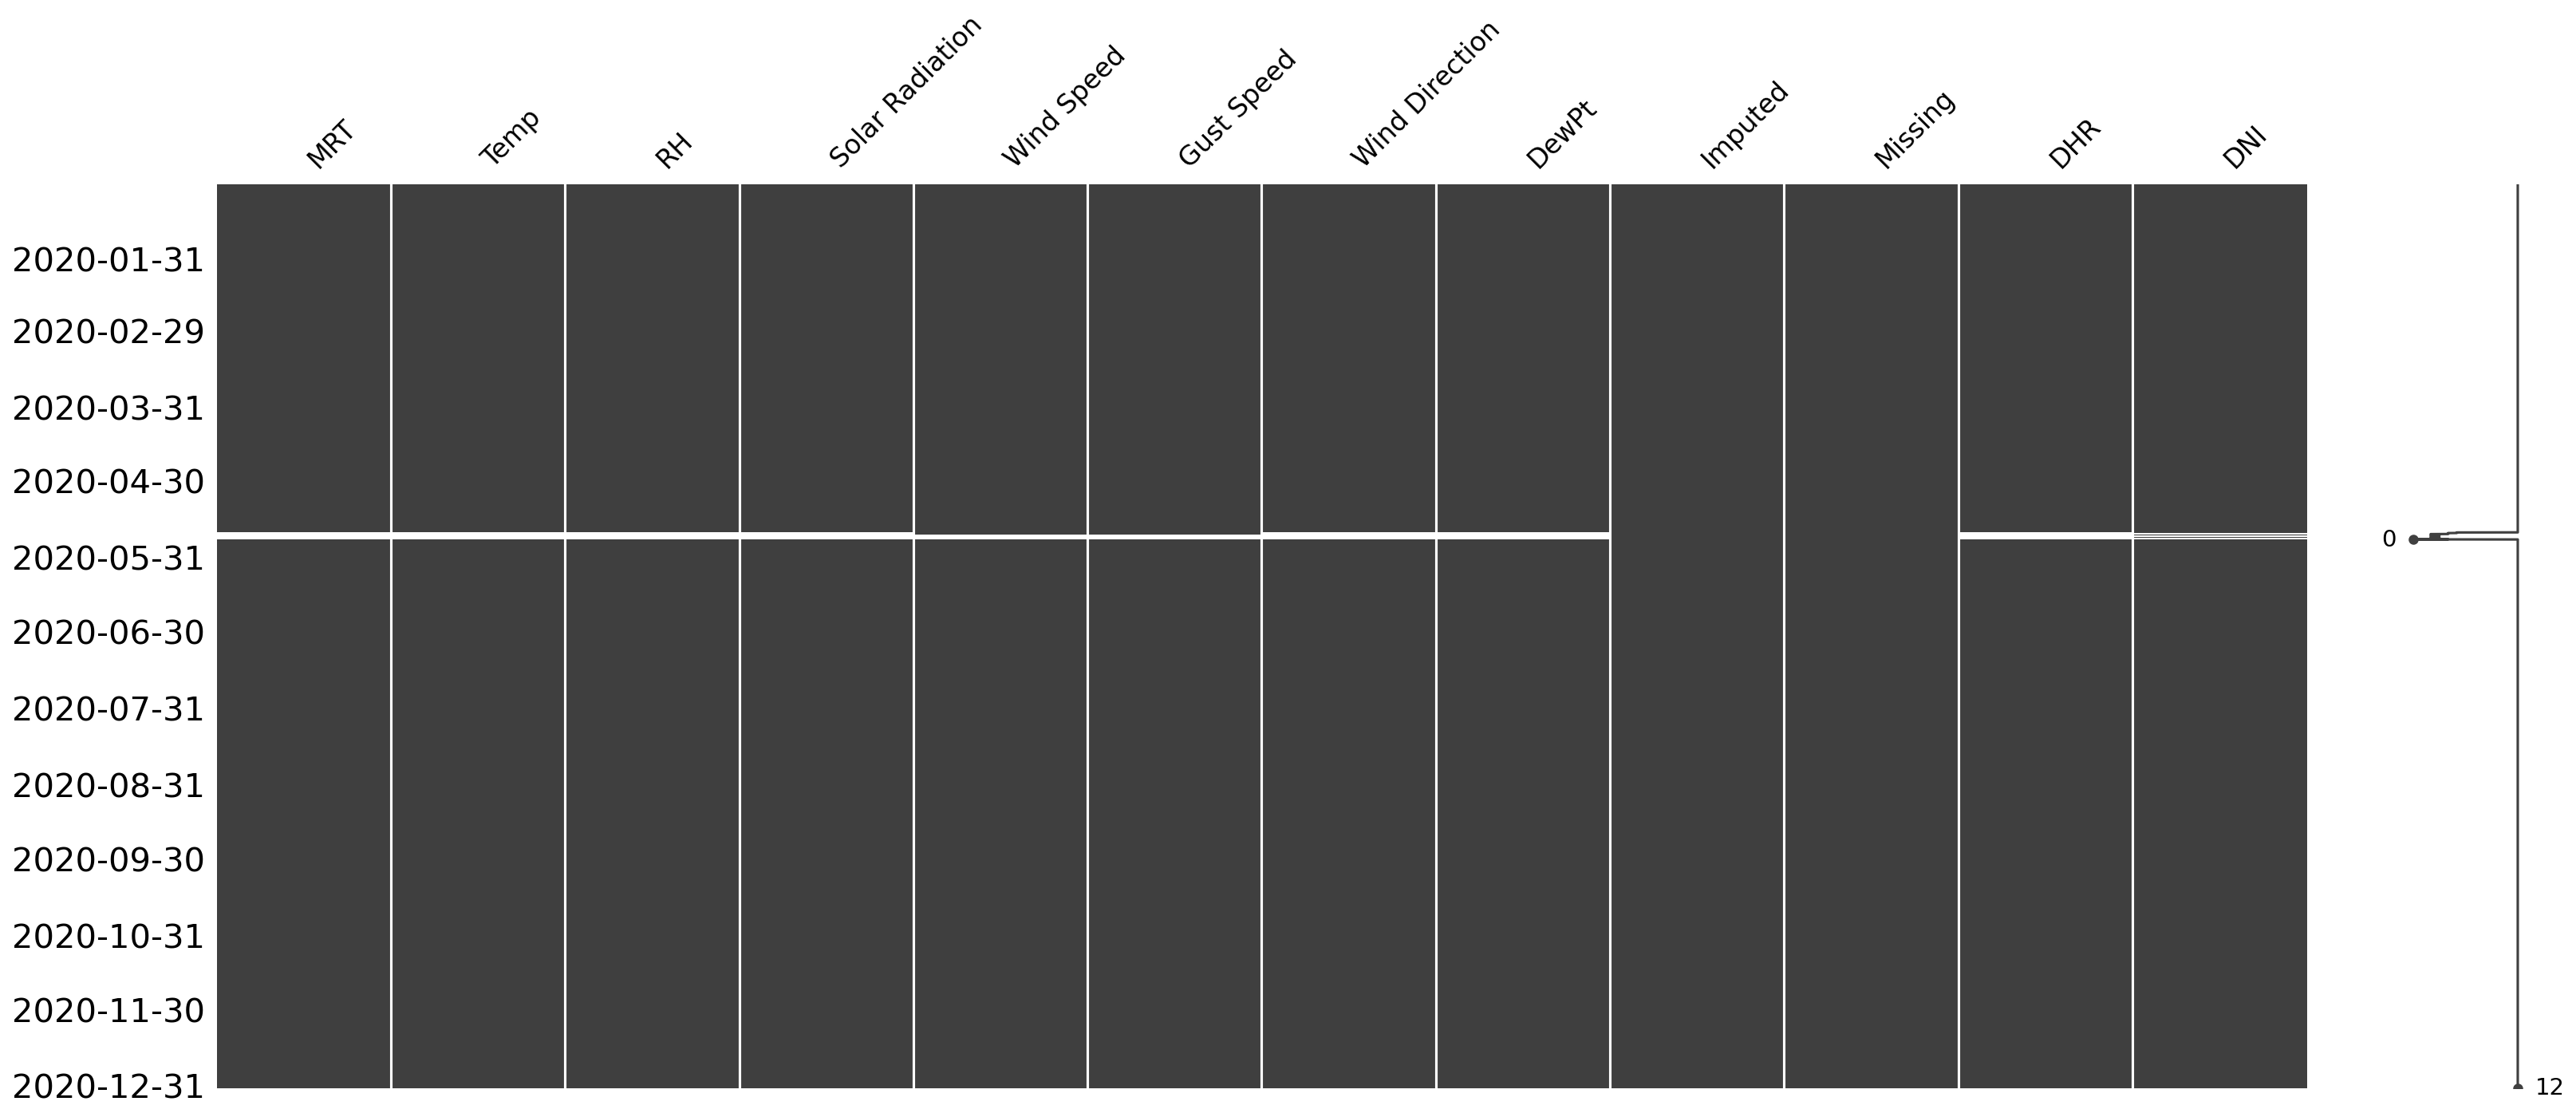

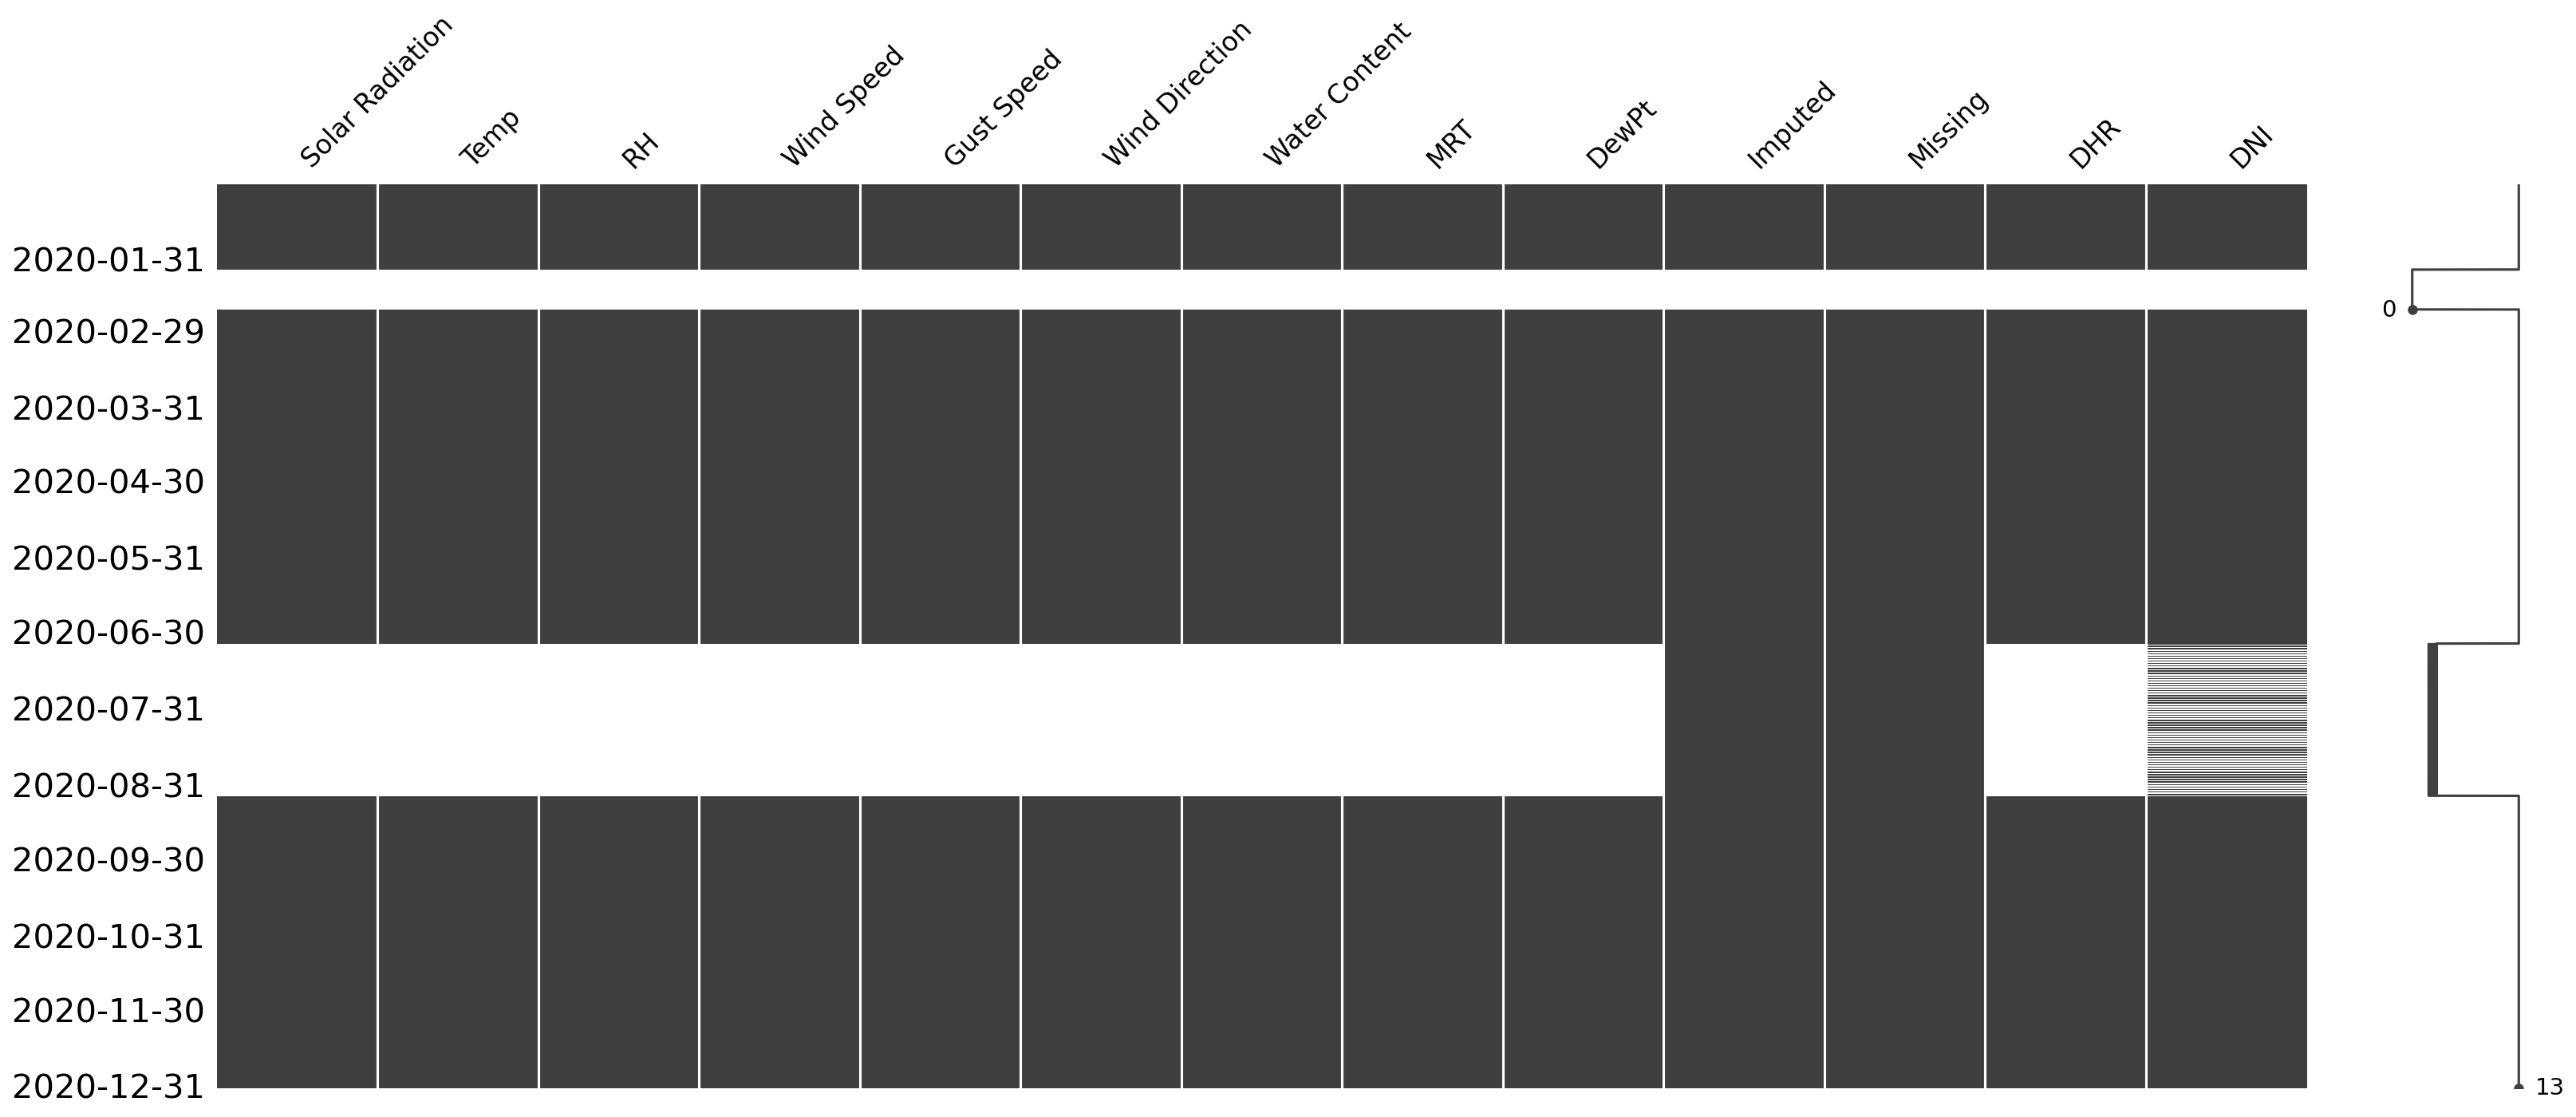

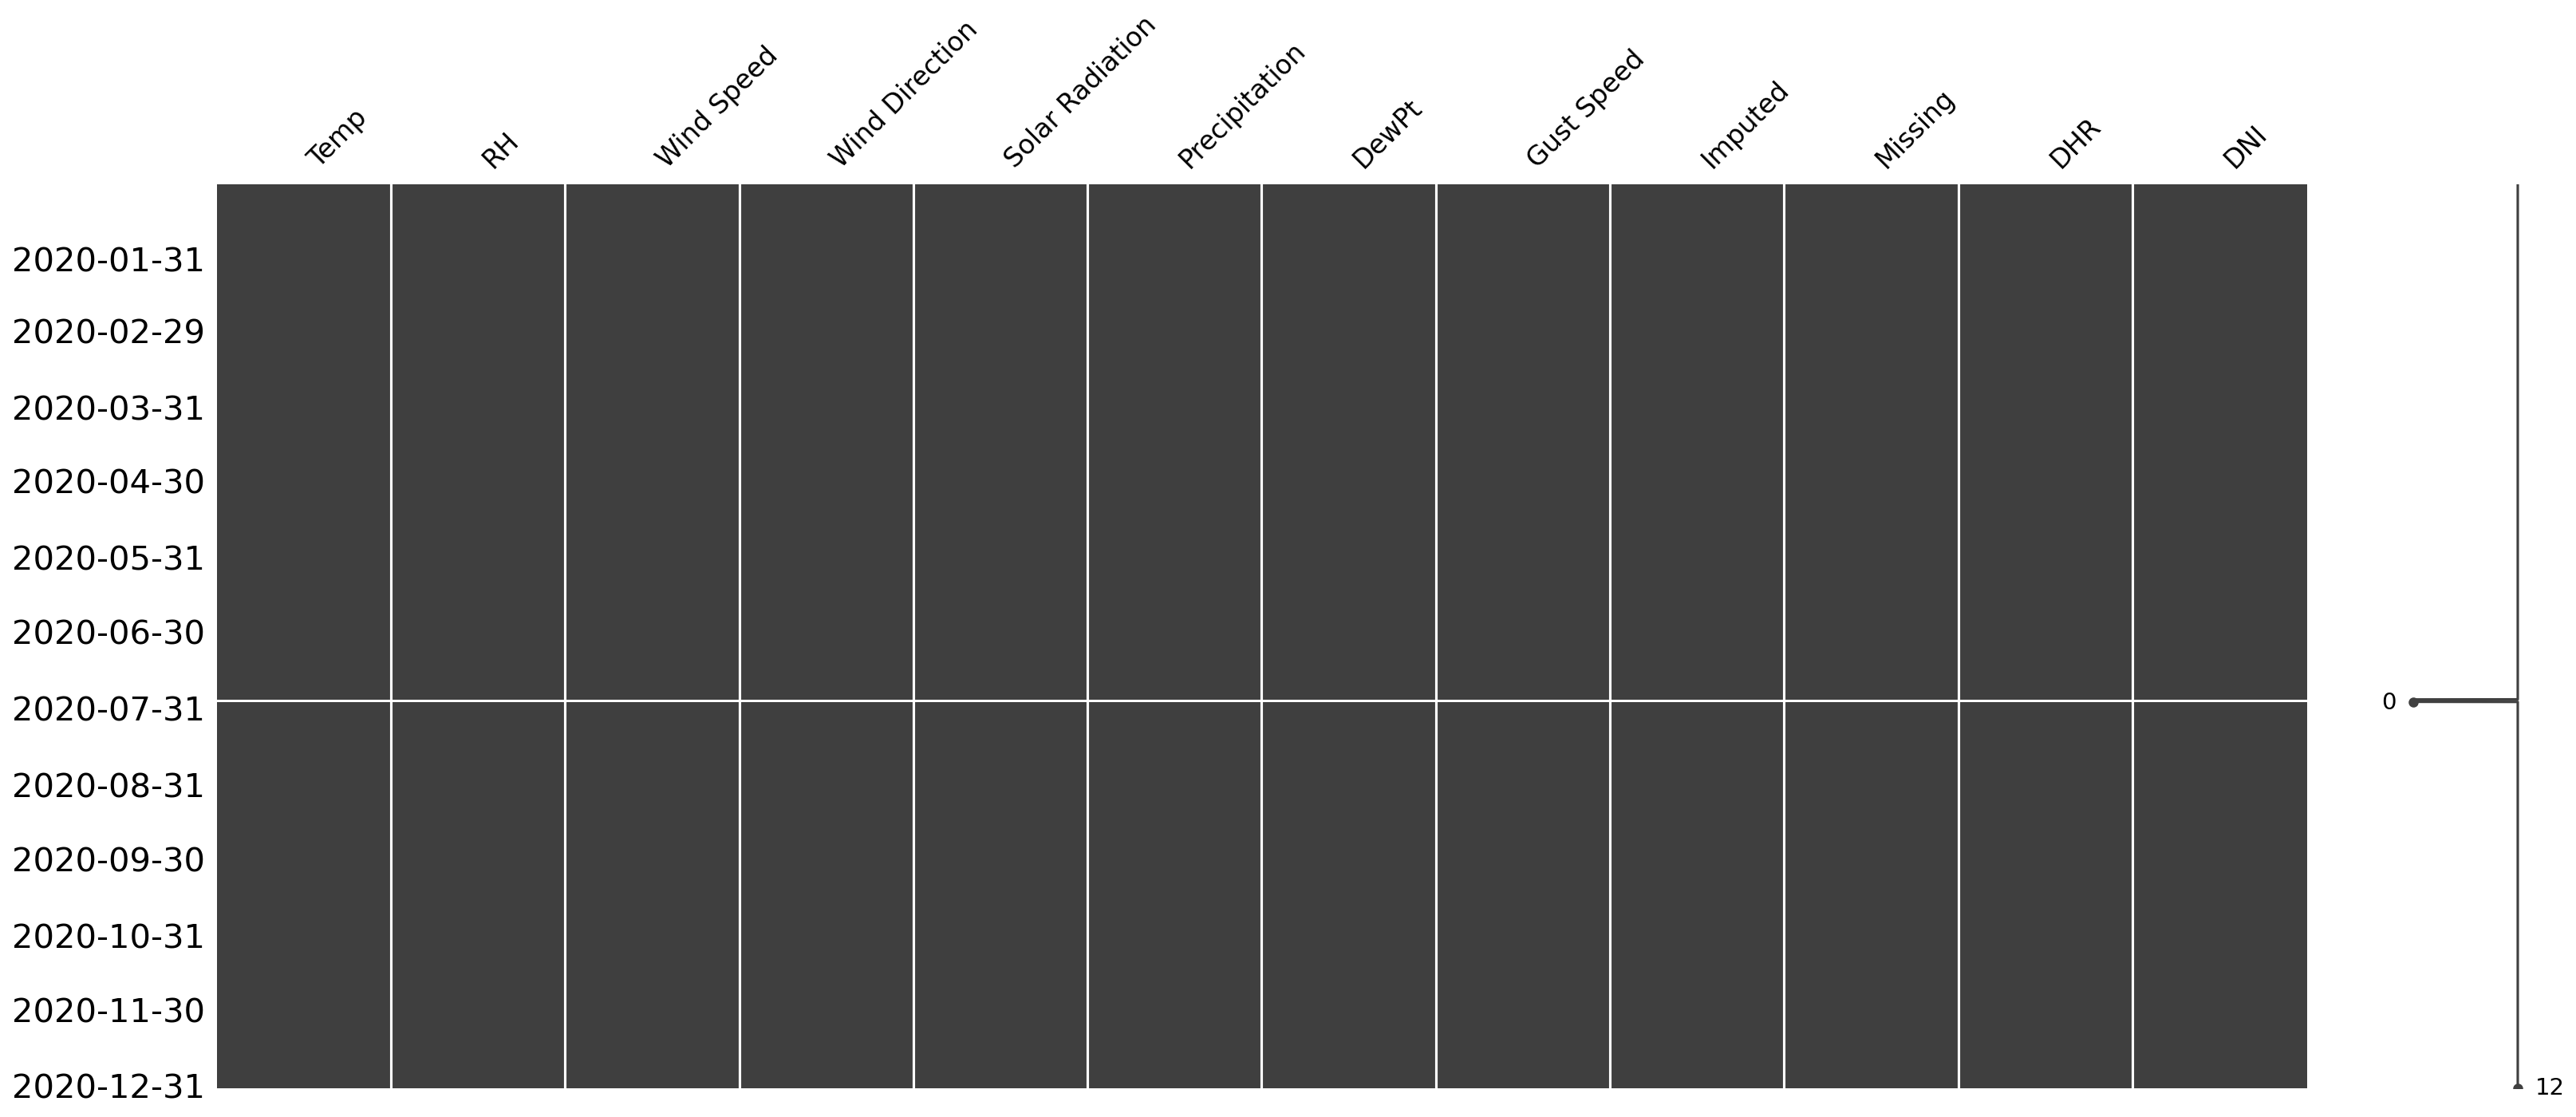

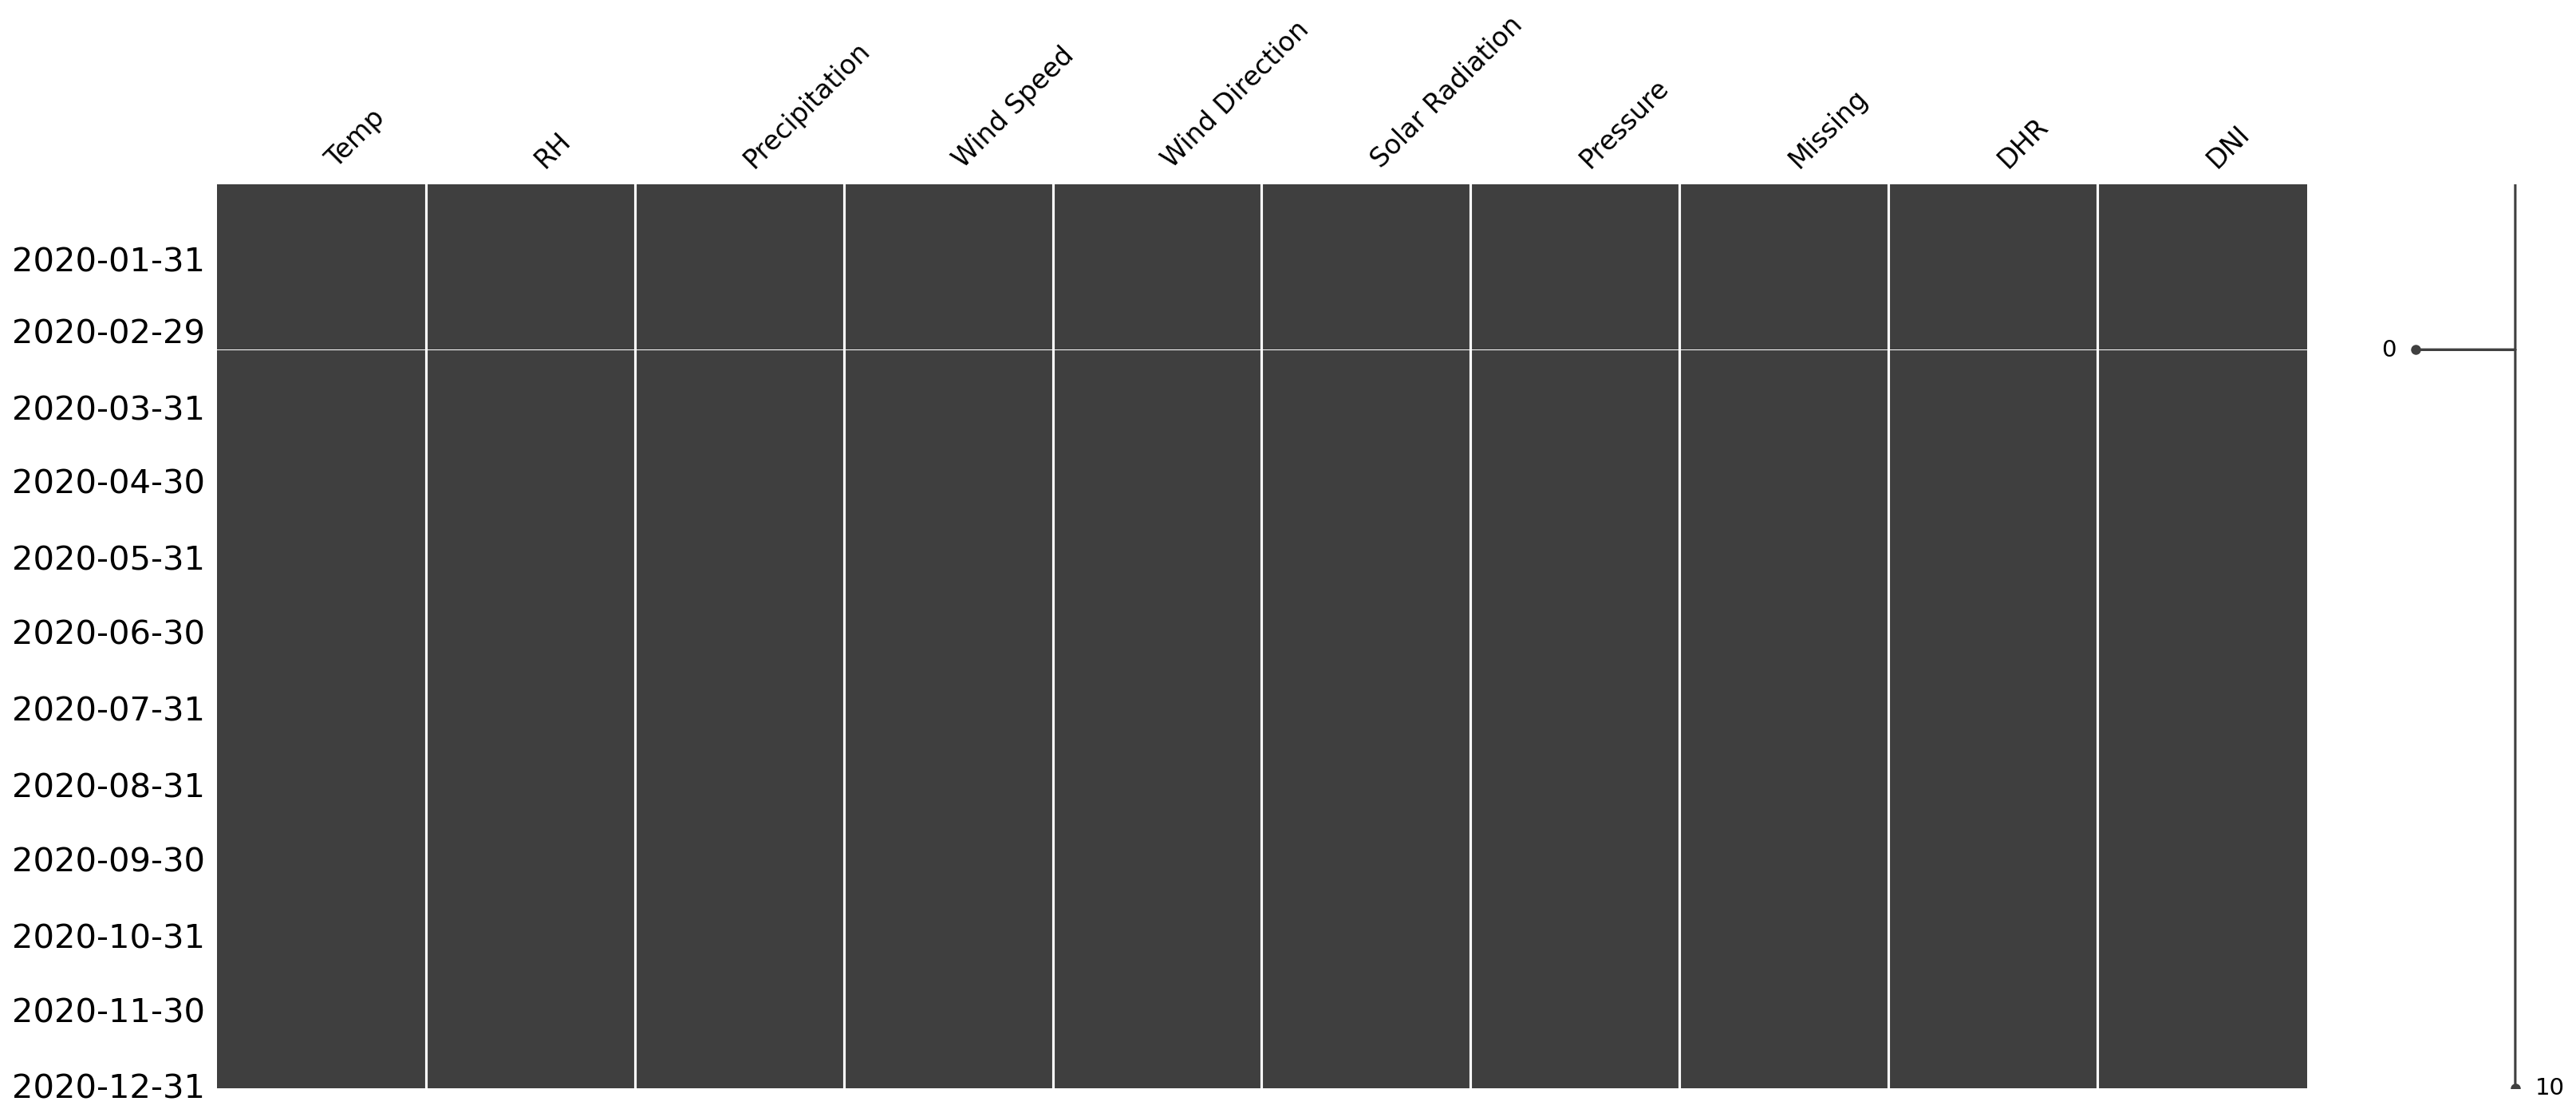

In [56]:
# Remove leap year

make_epw("DL1_NoLeap", 2020, df1, True)
make_epw("DL2_NoLeap", 2020, df2, True)
make_epw("DL3_NoLeap", 2020, df3, True)
make_epw("DL4_NoLeap", 2020, df4, True)
make_epw("GameFarmRoad_NoLeap", 2020, df5, True)
make_epw("Groton_NoLeap", 2020, df6, True)

In [61]:
get_1y_data(df5,2020).iloc[4970:5010,:]
#df5.iloc[8750:,:]

title,Temp,RH,Wind Speed,Wind Direction,Solar Radiation,Precipitation,DewPt,Gust Speed,Imputed,Missing,DHR,DNI
2020-07-26 02:00:00,17.78,94.90,0.680,93.50,0.00,0.0,16.76,1.095,0.0,0.0,0.000000,0.0
2020-07-26 03:00:00,17.44,95.50,0.697,78.18,0.00,0.0,16.54,0.988,0.0,0.0,0.000000,0.0
2020-07-26 04:00:00,16.97,95.80,0.715,85.90,0.00,0.0,16.13,0.952,0.0,0.0,0.000000,0.0
2020-07-26 05:00:00,16.61,96.00,0.742,79.80,0.23,0.0,15.81,1.024,0.0,0.0,0.230000,0.0
2020-07-26 06:00:00,16.71,96.00,0.639,95.80,43.03,0.0,15.91,0.952,0.0,0.0,41.739100,6.0
2020-07-26 07:00:00,18.57,91.40,0.621,76.06,165.15,0.0,16.85,0.988,0.0,0.0,144.700655,55.0
2020-07-26 08:00:00,21.89,73.78,0.536,35.97,321.45,0.0,16.64,1.131,0.0,0.0,228.672177,171.0
2020-07-26 09:00:00,24.87,66.40,1.323,280.00,495.79,0.0,18.15,2.204,0.0,0.0,284.843198,305.0
2020-07-26 10:00:00,26.41,52.21,1.663,287.40,648.61,0.0,16.85,2.562,0.0,0.0,314.044397,413.0
2020-07-26 11:00:00,27.27,51.97,1.395,289.80,763.28,0.0,17.67,2.490,0.0,0.0,321.222323,498.0


In [ ]:
a = epw()
a.read("DL4_Milstein_2019.epw")
day = 8
month = 12
year = 2019

hour_f = to_hour_of_year(0, day, month, year)
hour_t = to_hour_of_year(23, day, month,year)

print(hour_f, hour_t)

pd.set_option('display.max_rows', None)
a.dataframe.loc[hour_f-48:hour_t+48,['Wind Speed', 'Wind Direction']]
#a.dataframe.loc[:,['Wind Speed', 'Wind Direction']]

#display(a.dataframe)
